In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

In [292]:
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

**Load The Dataset**

In [6]:
Dataset = pd.read_csv('/content/Dataset.csv')

In [7]:
Dataset.head()

Patient Id  Patient Age Genes in mother's side Inherited from father  \
0  PID0x6418          2.0                    Yes                    No   
1  PID0x25d5          4.0                    Yes                   Yes   
2  PID0x4a82          6.0                    Yes                    No   
3  PID0x4ac8         12.0                    Yes                    No   
4  PID0x1bf7         11.0                    Yes                    No   

  Maternal gene Paternal gene  Blood cell count (mcL) Patient First Name  \
0           Yes            No                4.760603            Richard   
1            No            No                4.910669               Mike   
2            No            No                4.893297           Kimberly   
3           Yes            No                4.705280            Jeffery   
4           NaN           Yes                4.720703            Johanna   

  Family Name Father's name  ...  Birth defects  \
0         NaN         Larre  ...            NaN   
1         NaN        Brycen  ...       Multiple   
2         NaN        Nashon  ...       Singular   
3   Hoelscher        Aayaan  ...       Singular   
4    Stutzman         Suave  ...       Multiple   

   White Blood cell count (thousand per microliter) Blood test result  \
0                                          9.857562               NaN   
1                                          5.522560            normal   
2                                               NaN            normal   
3                                          7.919321      inconclusive   
4                                          4.098210               NaN   

  Symptom 1 Symptom 2 Symptom 3 Symptom 4  Symptom 5  \
0       1.0       1.0       1.0       1.0        1.0   
1       1.0       NaN       1.0       1.0        0.0   
2       0.0       1.0       1.0       1.0        1.0   
3       0.0       0.0       1.0       0.0        0.0   
4       0.0       0.0       0.0       0.0        NaN   

                               Genetic Disorder  \
0   Mitochondrial genetic inheritance disorders   
1                                           NaN   
2  Multifactorial genetic inheritance disorders   
3   Mitochondrial genetic inheritance disorders   
4  Multifactorial genetic inheritance disorders   

                     Disorder Subclass  
0  Leber's hereditary optic neuropathy  
1                      Cystic fibrosis  
2                             Diabetes  
3                       Leigh syndrome  
4                               Cancer  

[5 rows x 45 columns]

In [8]:
Dataset.shape

(22083, 45)

In [9]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Id                                        22083 non-null  object 
 1   Patient Age                                       20656 non-null  float64
 2   Genes in mother's side                            22083 non-null  object 
 3   Inherited from father                             21777 non-null  object 
 4   Maternal gene                                     19273 non-null  object 
 5   Paternal gene                                     22083 non-null  object 
 6   Blood cell count (mcL)                            22083 non-null  float64
 7   Patient First Name                                22083 non-null  object 
 8   Family Name                                       12392 non-null  object 
 9   Father's name    

In [10]:
Dataset.describe().transpose()

count       mean  \
Patient Age                                       20656.0   6.974148   
Blood cell count (mcL)                            22083.0   4.898871   
Mother's age                                      16047.0  34.526454   
Father's age                                      16097.0  41.972852   
Test 1                                            19956.0   0.000000   
Test 2                                            19931.0   0.000000   
Test 3                                            19936.0   0.000000   
Test 4                                            19943.0   1.000000   
Test 5                                            19913.0   0.000000   
No. of previous abortion                          19921.0   2.003062   
White Blood cell count (thousand per microliter)  19935.0   7.486224   
Symptom 1                                         19928.0   0.592483   
Symptom 2                                         19861.0   0.551886   
Symptom 3                                         19982.0   0.536233   
Symptom 4                                         19970.0   0.497747   
Symptom 5                                         19930.0   0.461917   

                                                        std        min  \
Patient Age                                        4.319475   0.000000   
Blood cell count (mcL)                             0.199663   4.092727   
Mother's age                                       9.852598  18.000000   
Father's age                                      13.035501  20.000000   
Test 1                                             0.000000   0.000000   
Test 2                                             0.000000   0.000000   
Test 3                                             0.000000   0.000000   
Test 4                                             0.000000   1.000000   
Test 5                                             0.000000   0.000000   
No. of previous abortion                           1.411919   0.000000   
White Blood cell count (thousand per microliter)   2.653393   3.000000   
Symptom 1                                          0.491385   0.000000   
Symptom 2                                          0.497313   0.000000   
Symptom 3                                          0.498698   0.000000   
Symptom 4                                          0.500007   0.000000   
Symptom 5                                          0.498560   0.000000   

                                                        25%        50%  \
Patient Age                                        3.000000   7.000000   
Blood cell count (mcL)                             4.763109   4.899399   
Mother's age                                      26.000000  35.000000   
Father's age                                      31.000000  42.000000   
Test 1                                             0.000000   0.000000   
Test 2                                             0.000000   0.000000   
Test 3                                             0.000000   0.000000   
Test 4                                             1.000000   1.000000   
Test 5                                             0.000000   0.000000   
No. of previous abortion                           1.000000   2.000000   
White Blood cell count (thousand per microliter)   5.424703   7.477132   
Symptom 1                                          0.000000   1.000000   
Symptom 2                                          0.000000   1.000000   
Symptom 3                                          0.000000   1.000000   
Symptom 4                                          0.000000   0.000000   
Symptom 5                                          0.000000   0.000000   

                                                        75%        max  
Patient Age                                       11.000000  14.000000  
Blood cell count (mcL)                             5.033830   5.609829  
Mother's age                                      43.000000  51.000000  
Father's age     

In [11]:
Dataset.isnull().sum()

Patient Id                                             0
Patient Age                                         1427
Genes in mother's side                                 0
Inherited from father                                306
Maternal gene                                       2810
Paternal gene                                          0
Blood cell count (mcL)                                 0
Patient First Name                                     0
Family Name                                         9691
Father's name                                          0
Mother's age                                        6036
Father's age                                        5986
Institute Name                                      5106
Location of Institute                                  0
Status                                                 0
Respiratory Rate (breaths/min)                      2149
Heart Rate (rates/min                               2113
Test 1                                              2127
Test 2                                              2152
Test 3                                              2147
Test 4                                              2140
Test 5                                              2170
Parental consent                                    2125
Follow-up                                           2166
Gender                                              2173
Birth asphyxia                                      2139
Autopsy shows birth defect (if applicable)          4392
Place of birth                                      2124
Folic acid details (peri-conceptional)              2117
H/O serious maternal illness                        2152
H/O radiation exposure (x-ray)                      2153
H/O substance abuse                                 2195
Assisted conception IVF/ART                         2122
History of anomalies in previous pregnancies        2172
No. of previous abortion                            2162
Birth defects                                       2154
White Blood cell count (thousand per microliter)    2148
Blood test result                                   2145
Symptom 1                                           2155
Symptom 2                                           2222
Symptom 3                                           2101
Symptom 4                                           2113
Symptom 5                                           2153
Genetic Disorder                                    2146
Disorder Subclass                                   2168
dtype: int64

## **Handle Missing Value**

In [12]:
def impute_numeric_with_kde(df, column_name, valid_range=None):
    """
    Impute missing values in a numeric column using KDE per Genetic Disorder.

    Parameters:
    - df: DataFrame containing the data
    - column_name: Name of the column to impute
    - valid_range: Tuple of (min, max) to clip imputed values (optional)

    Returns:
    - DataFrame with imputed values
    """
    # Get non-missing values per Genetic Disorder
    dist_0 = df.loc[(df['Genetic Disorder'] == 0) & df[column_name].notna(), column_name].values
    dist_1 = df.loc[(df['Genetic Disorder'] == 1) & df[column_name].notna(), column_name].values
    dist_2 = df.loc[(df['Genetic Disorder'] == 2) & df[column_name].notna(), column_name].values
    overall_dist = df.loc[df[column_name].notna(), column_name].values

    # Masks for missing values
    mask_0 = (df['Genetic Disorder'] == 0) & df[column_name].isna()
    mask_1 = (df['Genetic Disorder'] == 1) & df[column_name].isna()
    mask_2 = (df['Genetic Disorder'] == 2) & df[column_name].isna()

    np.random.seed(42)  # For reproducibility

    # Impute using KDE
    if len(dist_0) > 0:
        kde_0 = gaussian_kde(dist_0)
        samples_0 = kde_0.resample(mask_0.sum())[0]
        samples_0 = np.round(samples_0)  # Round to integers
        if valid_range:
            samples_0 = np.clip(samples_0, valid_range[0], valid_range[1])  # Clip to valid range
        df.loc[mask_0, column_name] = samples_0
    else:
        samples_0 = np.random.choice(overall_dist, size=mask_0.sum(), replace=True)
        if valid_range:
            samples_0 = np.clip(samples_0, valid_range[0], valid_range[1])
        df.loc[mask_0, column_name] = samples_0

    if len(dist_1) > 0:
        kde_1 = gaussian_kde(dist_1)
        samples_1 = kde_1.resample(mask_1.sum())[0]
        samples_1 = np.round(samples_1)
        if valid_range:
            samples_1 = np.clip(samples_1, valid_range[0], valid_range[1])
        df.loc[mask_1, column_name] = samples_1
    else:
        samples_1 = np.random.choice(overall_dist, size=mask_1.sum(), replace=True)
        if valid_range:
            samples_1 = np.clip(samples_1, valid_range[0], valid_range[1])
        df.loc[mask_1, column_name] = samples_1

    if len(dist_2) > 0:
        kde_2 = gaussian_kde(dist_2)
        samples_2 = kde_2.resample(mask_2.sum())[0]
        samples_2 = np.round(samples_2)
        if valid_range:
            samples_2 = np.clip(samples_2, valid_range[0], valid_range[1])
        df.loc[mask_2, column_name] = samples_2
    else:
        samples_2 = np.random.choice(overall_dist, size=mask_2.sum(), replace=True)
        if valid_range:
            samples_2 = np.clip(samples_2, valid_range[0], valid_range[1])
        df.loc[mask_2, column_name] = samples_2

    return df

In [13]:
def impute_categorical_with_proportions_improved(df, column_name):
    overall_data = df.loc[df[column_name].notna(), column_name]
    overall_proportions = overall_data.value_counts(normalize=True)
    overall_categories = overall_proportions.index
    overall_proportions = overall_proportions.values

    for disorder in [0, 1, 2]:
        mask_non_missing = (df['Genetic Disorder'] == disorder) & df[column_name].notna()
        mask_missing = (df['Genetic Disorder'] == disorder) & df[column_name].isna()

        if mask_missing.sum() == 0:
            continue

        if mask_non_missing.sum() > 0:
            group_data = df.loc[mask_non_missing, column_name]
            group_proportions = group_data.value_counts(normalize=True)
            for cat in overall_categories:
                if cat not in group_proportions.index:
                    group_proportions[cat] = 0
            group_proportions = group_proportions[overall_categories]
            categories = group_proportions.index
            proportions = group_proportions.values
        else:
            categories = overall_categories
            proportions = overall_proportions

        np.random.seed(42)
        imputed_values = np.random.choice(categories, size=mask_missing.sum(), p=proportions, replace=True)
        df.loc[mask_missing, column_name] = imputed_values

    return df

**Patient Id**

In [14]:
Dataset["Patient Id"]

0        PID0x6418
1        PID0x25d5
2        PID0x4a82
3        PID0x4ac8
4        PID0x1bf7
           ...    
22078    PID0x5598
22079    PID0x19cb
22080    PID0x3c4f
22081     PID0x13a
22082    PID0x9332
Name: Patient Id, Length: 22083, dtype: object

Every patient have different "Patient Id". We will drop this column.

In [15]:
Dataset = Dataset.drop(columns=["Patient Id"])

In [16]:
Dataset.head()

Patient Age Genes in mother's side Inherited from father Maternal gene  \
0          2.0                    Yes                    No           Yes   
1          4.0                    Yes                   Yes            No   
2          6.0                    Yes                    No            No   
3         12.0                    Yes                    No           Yes   
4         11.0                    Yes                    No           NaN   

  Paternal gene  Blood cell count (mcL) Patient First Name Family Name  \
0            No                4.760603            Richard         NaN   
1            No                4.910669               Mike         NaN   
2            No                4.893297           Kimberly         NaN   
3            No                4.705280            Jeffery   Hoelscher   
4           Yes                4.720703            Johanna    Stutzman   

  Father's name  Mother's age  ...  Birth defects  \
0         Larre           NaN  ...            NaN   
1        Brycen           NaN  ...       Multiple   
2        Nashon          41.0  ...       Singular   
3        Aayaan          21.0  ...       Singular   
4         Suave          32.0  ...       Multiple   

  White Blood cell count (thousand per microliter) Blood test result  \
0                                         9.857562               NaN   
1                                         5.522560            normal   
2                                              NaN            normal   
3                                         7.919321      inconclusive   
4                                         4.098210               NaN   

  Symptom 1 Symptom 2 Symptom 3  Symptom 4  Symptom 5  \
0       1.0       1.0       1.0        1.0        1.0   
1       1.0       NaN       1.0        1.0        0.0   
2       0.0       1.0       1.0        1.0        1.0   
3       0.0       0.0       1.0        0.0        0.0   
4       0.0       0.0       0.0        0.0        NaN   

                               Genetic Disorder  \
0   Mitochondrial genetic inheritance disorders   
1                                           NaN   
2  Multifactorial genetic inheritance disorders   
3   Mitochondrial genetic inheritance disorders   
4  Multifactorial genetic inheritance disorders   

                     Disorder Subclass  
0  Leber's hereditary optic neuropathy  
1                      Cystic fibrosis  
2                             Diabetes  
3                       Leigh syndrome  
4                               Cancer  

[5 rows x 44 columns]

**Patient First Name**

In [17]:
Dataset["Patient First Name"]

0         Richard
1            Mike
2        Kimberly
3         Jeffery
4         Johanna
           ...   
22078        Lynn
22079     Matthew
22080        John
22081      Sharon
22082      Andrew
Name: Patient First Name, Length: 22083, dtype: object

In [18]:
Dataset["Patient First Name"].value_counts()

Patient First Name
James        420
John         372
Robert       355
Mary         329
Michael      321
            ... 
Sharice        1
Shasta         1
Maryalice      1
Roxann         1
Cathrine       1
Name: count, Length: 2524, dtype: int64

Lot's of different value.

In [19]:
Dataset = Dataset.drop(columns="Patient First Name")

**Family Name**

In [20]:
Dataset["Family Name"]

0              NaN
1              NaN
2              NaN
3        Hoelscher
4         Stutzman
           ...    
22078          NaN
22079       Farley
22080          NaN
22081          NaN
22082         Mose
Name: Family Name, Length: 22083, dtype: object

Family Name column have also lot;s of unique value

In [21]:
Dataset = Dataset.drop(columns="Family Name")

**Father's name**

In [22]:
Dataset["Father's name"]

0            Larre
1           Brycen
2           Nashon
3           Aayaan
4            Suave
           ...    
22078    Alhassane
22079    Dartanion
22080       Cavani
22081        Bomer
22082         Eban
Name: Father's name, Length: 22083, dtype: object

In [23]:
Dataset = Dataset.drop(columns="Father's name")

In [24]:
Dataset = Dataset.drop(columns=["Institute Name","Location of Institute","Disorder Subclass"])

**Mother's age**

In [25]:
Dataset["Mother's age"]

0         NaN
1         NaN
2        41.0
3        21.0
4        32.0
         ... 
22078    35.0
22079     NaN
22080    35.0
22081    19.0
22082    32.0
Name: Mother's age, Length: 22083, dtype: float64

In [26]:
Dataset["Mother's age"].isnull().sum()

6036

In [27]:
Dataset = Dataset.drop(columns="Mother's age")

**Father's age**

In [28]:
Dataset["Father's age"]

0         NaN
1        23.0
2        22.0
3         NaN
4         NaN
         ... 
22078    64.0
22079    56.0
22080    51.0
22081     NaN
22082    62.0
Name: Father's age, Length: 22083, dtype: float64

In [29]:
Dataset["Father's age"].isnull().sum()

5986

In [30]:
Dataset = Dataset.drop(columns="Father's age")

In [31]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 36 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Age                                       20656 non-null  float64
 1   Genes in mother's side                            22083 non-null  object 
 2   Inherited from father                             21777 non-null  object 
 3   Maternal gene                                     19273 non-null  object 
 4   Paternal gene                                     22083 non-null  object 
 5   Blood cell count (mcL)                            22083 non-null  float64
 6   Status                                            22083 non-null  object 
 7   Respiratory Rate (breaths/min)                    19934 non-null  object 
 8   Heart Rate (rates/min                             19970 non-null  object 
 9   Test 1           

In [32]:
Dataset.isnull().sum()

Patient Age                                         1427
Genes in mother's side                                 0
Inherited from father                                306
Maternal gene                                       2810
Paternal gene                                          0
Blood cell count (mcL)                                 0
Status                                                 0
Respiratory Rate (breaths/min)                      2149
Heart Rate (rates/min                               2113
Test 1                                              2127
Test 2                                              2152
Test 3                                              2147
Test 4                                              2140
Test 5                                              2170
Parental consent                                    2125
Follow-up                                           2166
Gender                                              2173
Birth asphyxia                                      2139
Autopsy shows birth defect (if applicable)          4392
Place of birth                                      2124
Folic acid details (peri-conceptional)              2117
H/O serious maternal illness                        2152
H/O radiation exposure (x-ray)                      2153
H/O substance abuse                                 2195
Assisted conception IVF/ART                         2122
History of anomalies in previous pregnancies        2172
No. of previous abortion                            2162
Birth defects                                       2154
White Blood cell count (thousand per microliter)    2148
Blood test result                                   2145
Symptom 1                                           2155
Symptom 2                                           2222
Symptom 3                                           2101
Symptom 4                                           2113
Symptom 5                                           2153
Genetic Disorder                                    2146
dtype: int64

**Genectic Disorder**

In [33]:
Dataset["Genetic Disorder"]

0         Mitochondrial genetic inheritance disorders
1                                                 NaN
2        Multifactorial genetic inheritance disorders
3         Mitochondrial genetic inheritance disorders
4        Multifactorial genetic inheritance disorders
                             ...                     
22078     Mitochondrial genetic inheritance disorders
22079    Multifactorial genetic inheritance disorders
22080     Mitochondrial genetic inheritance disorders
22081                                             NaN
22082    Multifactorial genetic inheritance disorders
Name: Genetic Disorder, Length: 22083, dtype: object

**Patients age**

In [34]:
Dataset["Genetic Disorder"].value_counts()

Genetic Disorder
Mitochondrial genetic inheritance disorders     10202
Single-gene inheritance diseases                 7664
Multifactorial genetic inheritance disorders     2071
Name: count, dtype: int64

<ipython-input-35-04ee9613e4a5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Genetic Disorder', data=Dataset, palette="bright")


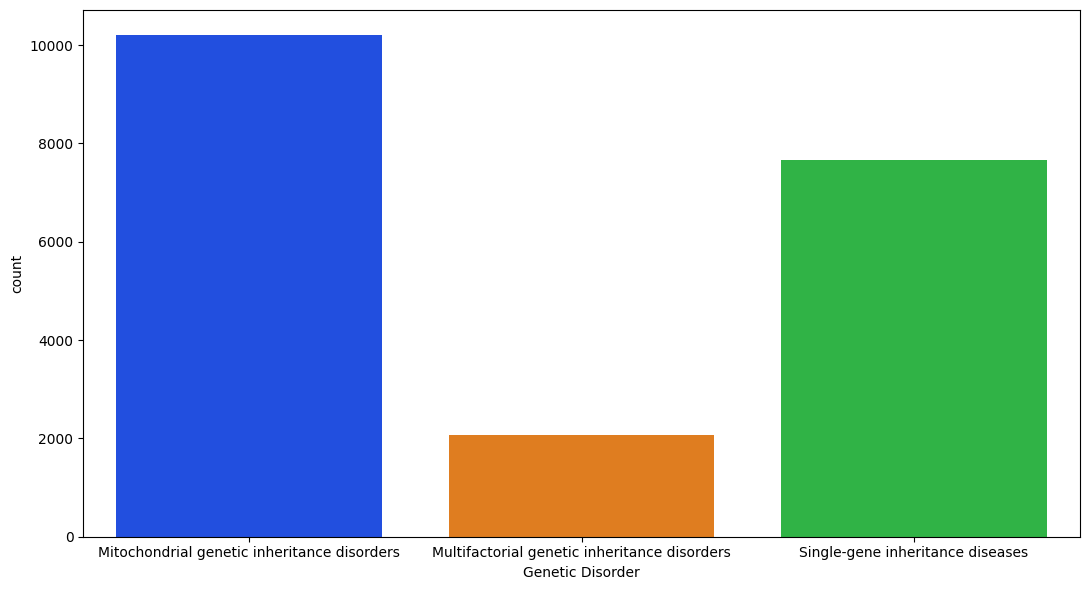

In [35]:
plt.figure(figsize=(11, 6))
sns.countplot(x='Genetic Disorder', data=Dataset, palette="bright")
plt.tight_layout()

In [36]:
Dataset["Genetic Disorder"].unique()

array(['Mitochondrial genetic inheritance disorders', nan,
       'Multifactorial genetic inheritance disorders',
       'Single-gene inheritance diseases'], dtype=object)

In target column have some missing value. we will drop these rows

In [37]:
Dataset = Dataset.dropna(subset=["Genetic Disorder"])

In [38]:
Dataset["Genetic Disorder"].unique()

array(['Mitochondrial genetic inheritance disorders',
       'Multifactorial genetic inheritance disorders',
       'Single-gene inheritance diseases'], dtype=object)

In [39]:
label_encoder = LabelEncoder()

In [40]:
Dataset["Genetic Disorder"] = label_encoder.fit_transform(Dataset["Genetic Disorder"])

In [41]:
Dataset["Genetic Disorder"].value_counts()

Genetic Disorder
0    10202
2     7664
1     2071
Name: count, dtype: int64

In [42]:
Dataset.isnull().sum()

Patient Age                                         1225
Genes in mother's side                                 0
Inherited from father                                261
Maternal gene                                       2424
Paternal gene                                          0
Blood cell count (mcL)                                 0
Status                                                 0
Respiratory Rate (breaths/min)                      1826
Heart Rate (rates/min                               1805
Test 1                                              1818
Test 2                                              1844
Test 3                                              1822
Test 4                                              1848
Test 5                                              1876
Parental consent                                    1819
Follow-up                                           1862
Gender                                              1844
Birth asphyxia                                      1848
Autopsy shows birth defect (if applicable)          3935
Place of birth                                      1820
Folic acid details (peri-conceptional)              1814
H/O serious maternal illness                        1824
H/O radiation exposure (x-ray)                      1830
H/O substance abuse                                 1900
Assisted conception IVF/ART                         1847
History of anomalies in previous pregnancies        1893
No. of previous abortion                            1828
Birth defects                                       1839
White Blood cell count (thousand per microliter)    1849
Blood test result                                   1833
Symptom 1                                           1844
Symptom 2                                           1898
Symptom 3                                           1797
Symptom 4                                           1821
Symptom 5                                           1848
Genetic Disorder                                       0
dtype: int64

In [43]:
Dataset.shape

(19937, 36)

**Patient Age**

<Axes: xlabel='Patient Age', ylabel='Genetic Disorder'>

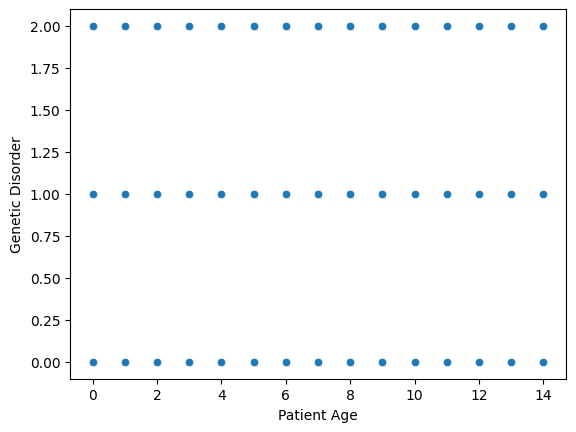

In [44]:
sns.scatterplot(x="Patient Age", y="Genetic Disorder", data=Dataset)

In [45]:
Dataset["Patient Age"].isnull().sum()

1225

<ipython-input-46-e532044488a3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Patient Age', data=Dataset, palette="bright")


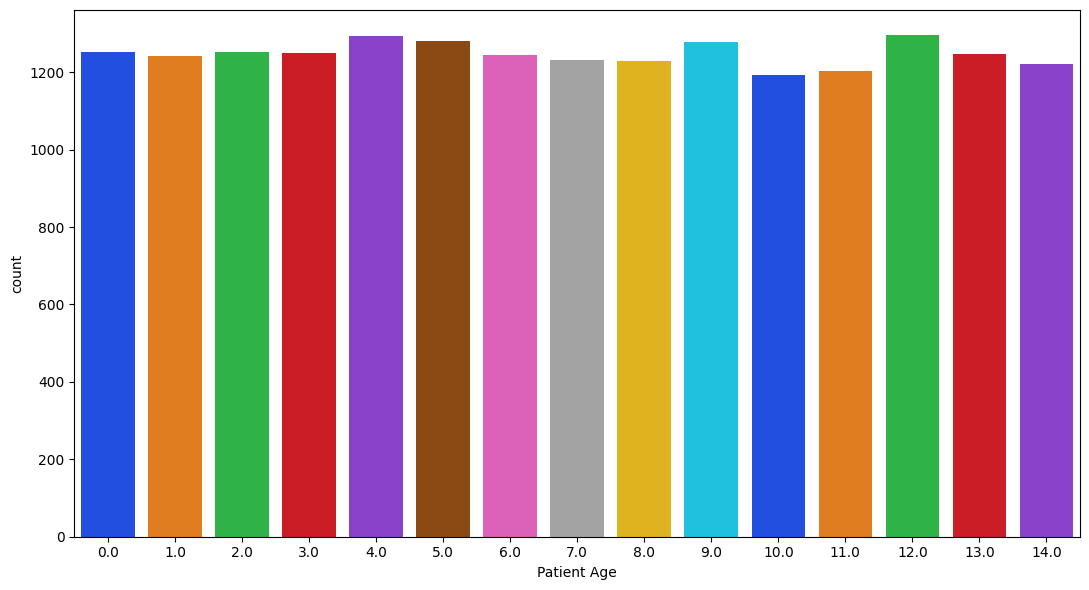

In [46]:
plt.figure(figsize=(11, 6))
sns.countplot(x='Patient Age', data=Dataset, palette="bright")
plt.tight_layout()

In [47]:
# Handle missing value
Dataset = impute_numeric_with_kde(Dataset, 'Patient Age', valid_range=(0, 14))

In [48]:
Dataset["Patient Age"].isnull().sum()

0

<ipython-input-49-e532044488a3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Patient Age', data=Dataset, palette="bright")


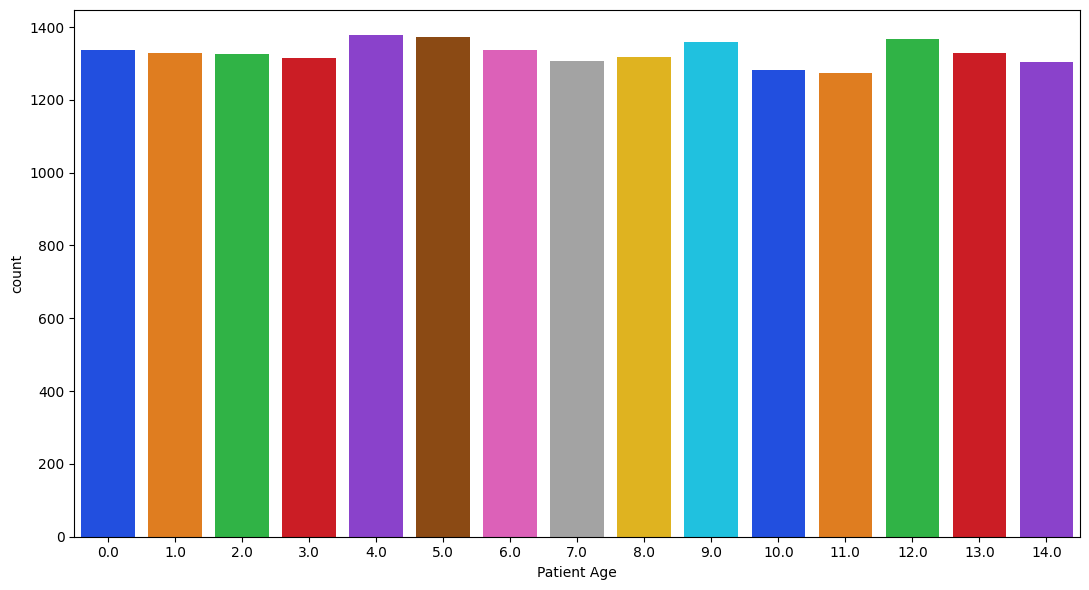

In [49]:
plt.figure(figsize=(11, 6))
sns.countplot(x='Patient Age', data=Dataset, palette="bright")
plt.tight_layout()

**Genes in mother's side**

In [50]:
Dataset["Genes in mother's side"]

0        Yes
2        Yes
3        Yes
4        Yes
5        Yes
        ... 
22077     No
22078    Yes
22079     No
22080    Yes
22082    Yes
Name: Genes in mother's side, Length: 19937, dtype: object

In [51]:
Dataset["Genes in mother's side"].value_counts()

Genes in mother's side
Yes    11848
No      8089
Name: count, dtype: int64

<ipython-input-52-69bce1c60f5a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Genes in mother's side", data=Dataset, palette="bright")


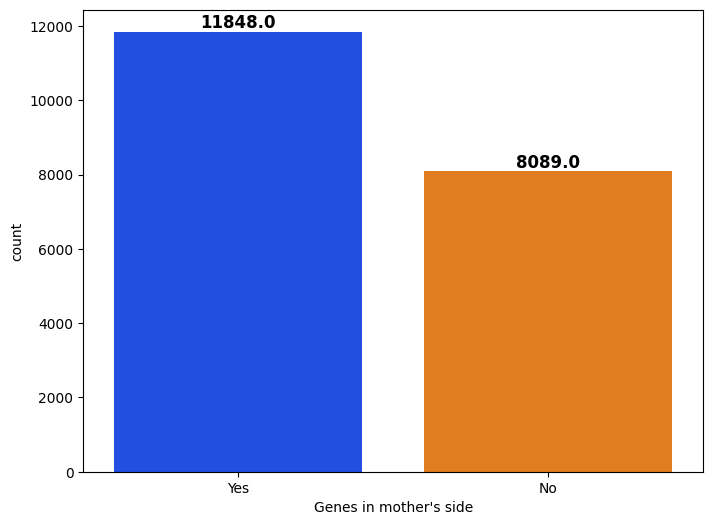

In [52]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Genes in mother's side", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

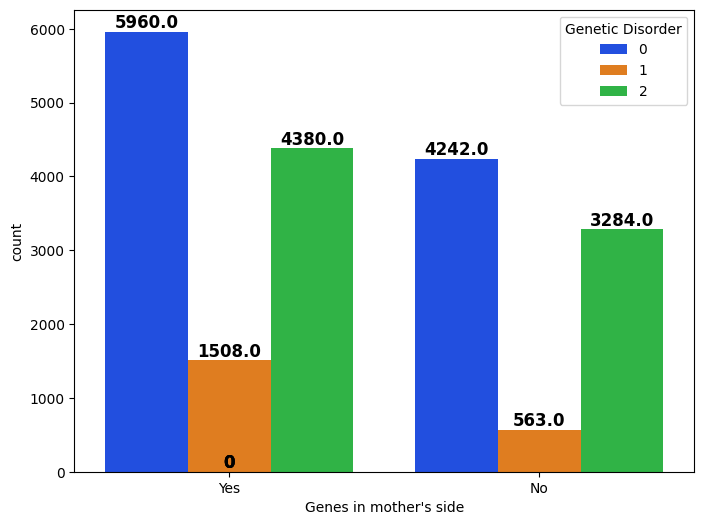

In [53]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Genes in mother's side", data=Dataset, hue="Genetic Disorder", palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [54]:
Dataset["Genes in mother's side"].isnull().sum()

0

In [55]:
Dataset["Genes in mother's side"].unique()

array(['Yes', 'No'], dtype=object)

**Inherited from father**

In [56]:
Dataset["Inherited from father"]

0         No
2         No
3         No
4         No
5         No
        ... 
22077    Yes
22078    Yes
22079    Yes
22080     No
22082     No
Name: Inherited from father, Length: 19937, dtype: object

In [57]:
Dataset["Inherited from father"].value_counts()

Inherited from father
No     11873
Yes     7803
Name: count, dtype: int64

<ipython-input-58-73f78d7a6036>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Inherited from father", data=Dataset, palette="bright")


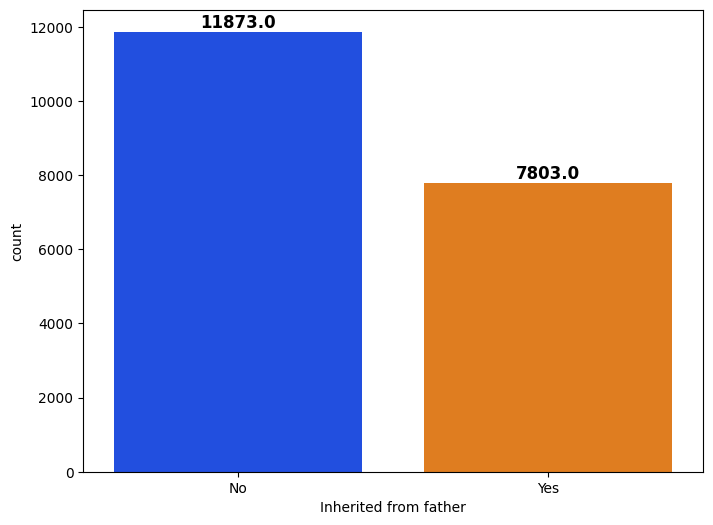

In [58]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Inherited from father", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

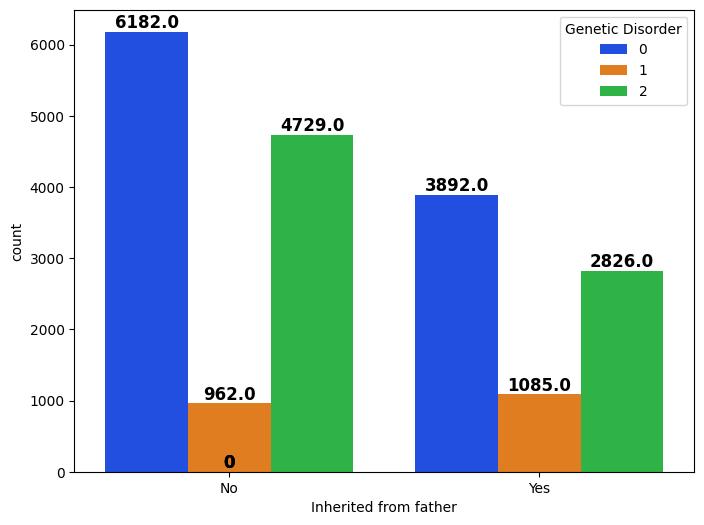

In [59]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Inherited from father", hue="Genetic Disorder", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [60]:
Dataset["Inherited from father"].isnull().sum()

261

In [61]:
Dataset["Inherited from father"].unique()

array(['No', 'Yes', nan], dtype=object)

In [62]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Inherited from father')

In [63]:
Dataset["Inherited from father"].isnull().sum()

0

In [64]:
Dataset["Inherited from father"].unique()

array(['No', 'Yes'], dtype=object)

<ipython-input-65-73f78d7a6036>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Inherited from father", data=Dataset, palette="bright")


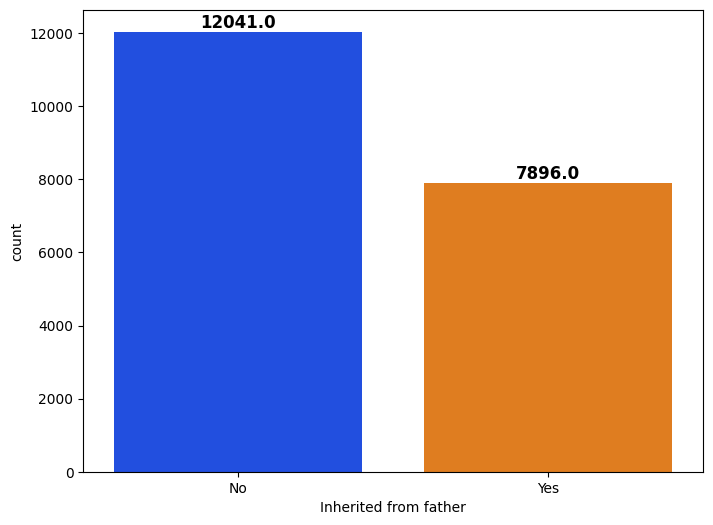

In [65]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Inherited from father", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

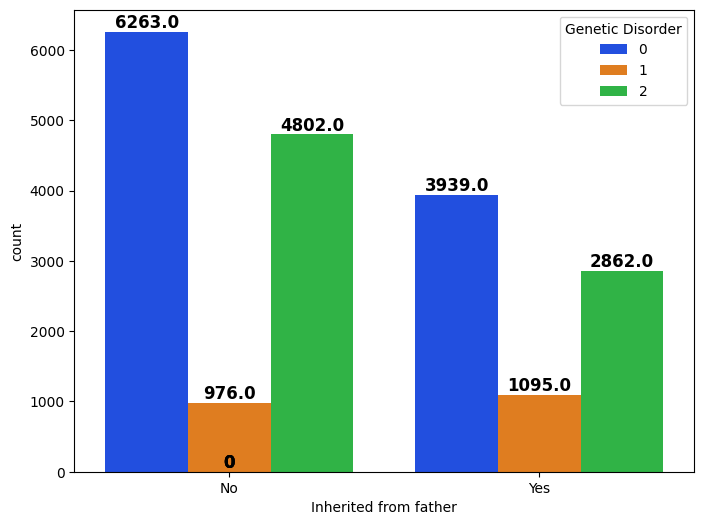

In [66]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Inherited from father", hue="Genetic Disorder", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Maternal gene**

In [67]:
Dataset["Maternal gene"]

0        Yes
2         No
3        Yes
4        NaN
5        Yes
        ... 
22077    Yes
22078    Yes
22079     No
22080    Yes
22082     No
Name: Maternal gene, Length: 19937, dtype: object

In [68]:
Dataset["Maternal gene"].value_counts()

Maternal gene
Yes    9671
No     7842
Name: count, dtype: int64

<ipython-input-69-a54d5d96ea63>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Maternal gene", data=Dataset, palette="bright")


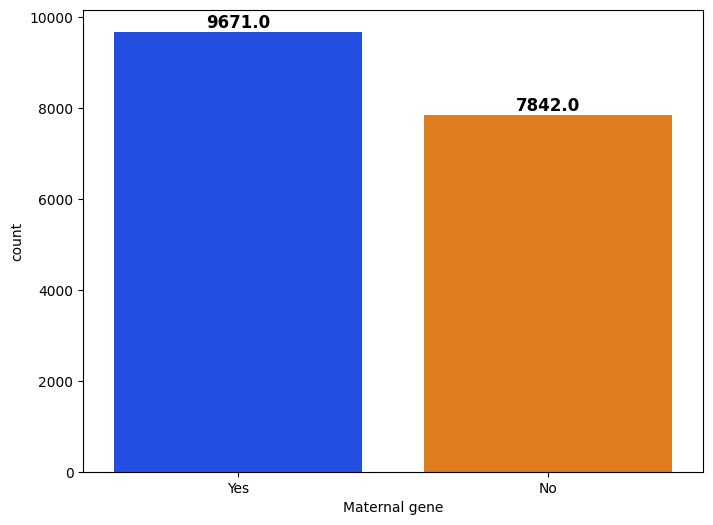

In [69]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Maternal gene", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')



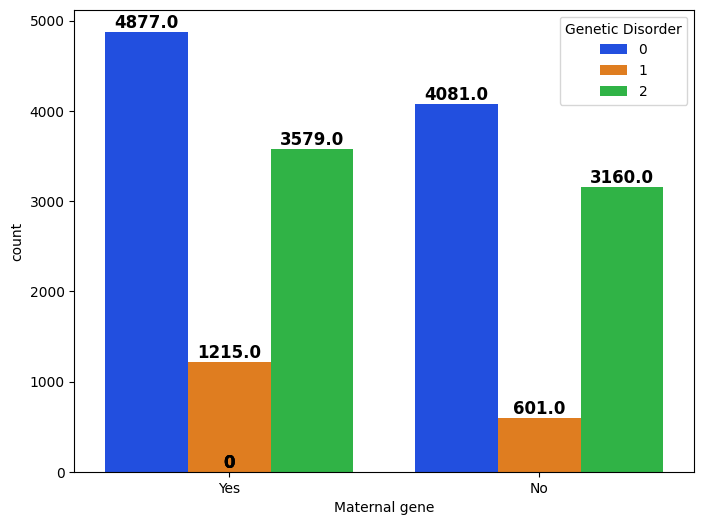

In [70]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Maternal gene", data=Dataset, hue="Genetic Disorder", palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [71]:
Dataset["Maternal gene"].isnull().sum()

2424

In [72]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Maternal gene')

In [73]:
Dataset["Maternal gene"].isnull().sum()

0

<ipython-input-74-0d7400fb3851>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Maternal gene", data=Dataset, palette="bright")


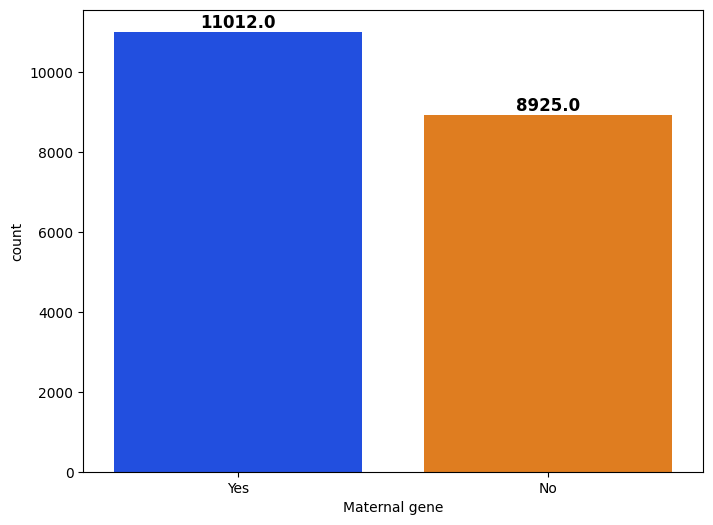

In [74]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Maternal gene", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [75]:
Dataset["Maternal gene"].value_counts()

Maternal gene
Yes    11012
No      8925
Name: count, dtype: int64

**Paternal gene**

In [76]:
Dataset["Paternal gene"]

0         No
2         No
3         No
4        Yes
5         No
        ... 
22077    Yes
22078     No
22079    Yes
22080     No
22082     No
Name: Paternal gene, Length: 19937, dtype: object

In [77]:
Dataset["Paternal gene"].value_counts()

Paternal gene
No     11297
Yes     8640
Name: count, dtype: int64

<ipython-input-78-6a11e6bb0b25>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Paternal gene", data=Dataset, palette="bright")


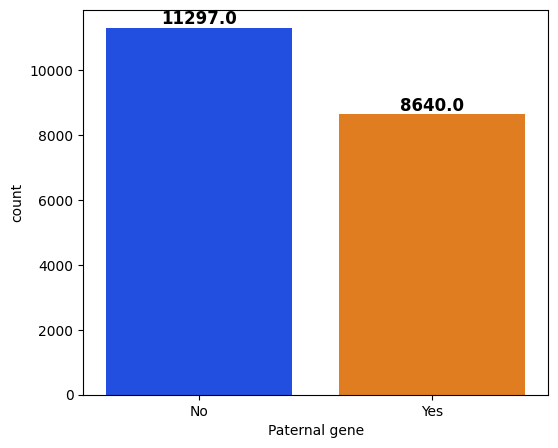

In [78]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Paternal gene", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [79]:
Dataset["Paternal gene"].unique()

array(['No', 'Yes'], dtype=object)

In [80]:
Dataset["Paternal gene"].isnull().sum()

0

**Blood cell count (mcL)**

In [81]:
Dataset["Blood cell count (mcL)"]

0        4.760603
2        4.893297
3        4.705280
4        4.720703
5        5.103188
           ...   
22077    5.012599
22078    5.258298
22079    4.974220
22080    5.186470
22082    4.738067
Name: Blood cell count (mcL), Length: 19937, dtype: float64

In [82]:
Dataset["Blood cell count (mcL)"].value_counts()

Blood cell count (mcL)
4.760603    1
4.592124    1
5.127216    1
4.643259    1
4.920964    1
           ..
5.106650    1
5.128740    1
4.769116    1
4.916183    1
4.738067    1
Name: count, Length: 19937, dtype: int64

<Axes: xlabel='Blood cell count (mcL)', ylabel='Genetic Disorder'>

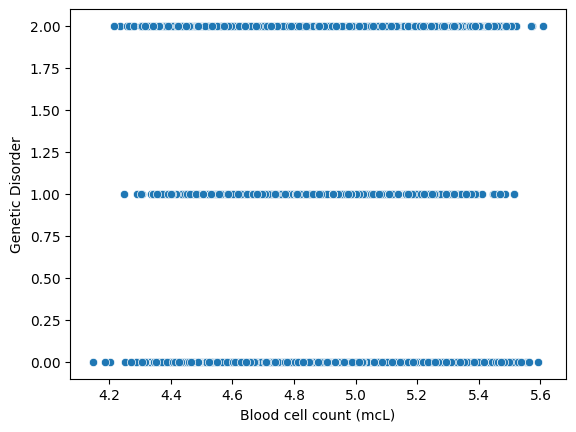

In [83]:
sns.scatterplot(x="Blood cell count (mcL)", y="Genetic Disorder", data=Dataset)

In [84]:
Dataset["Blood cell count (mcL)"].isnull().sum()

0

In [85]:
Dataset["Blood cell count (mcL)"].unique()

array([4.76060309, 4.89329743, 4.70528039, ..., 4.97422049, 5.1864702 ,
       4.73806671])

**Status**

In [86]:
Dataset["Status"]

0           Alive
2           Alive
3        Deceased
4           Alive
5        Deceased
           ...   
22077    Deceased
22078    Deceased
22079       Alive
22080    Deceased
22082    Deceased
Name: Status, Length: 19937, dtype: object

In [87]:
Dataset["Status"].value_counts()

Status
Alive       10011
Deceased     9926
Name: count, dtype: int64

<ipython-input-88-fb72c4ab0b58>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Status", data=Dataset, palette="bright")


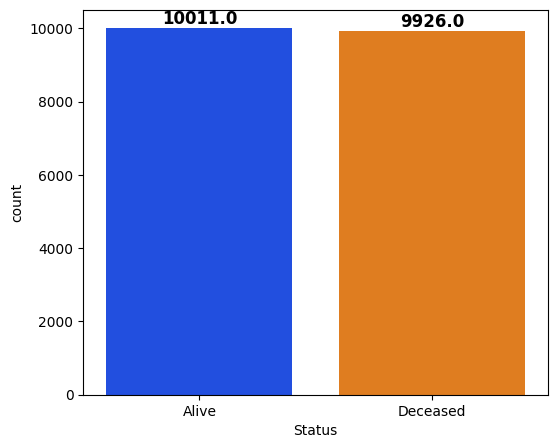

In [88]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Status", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

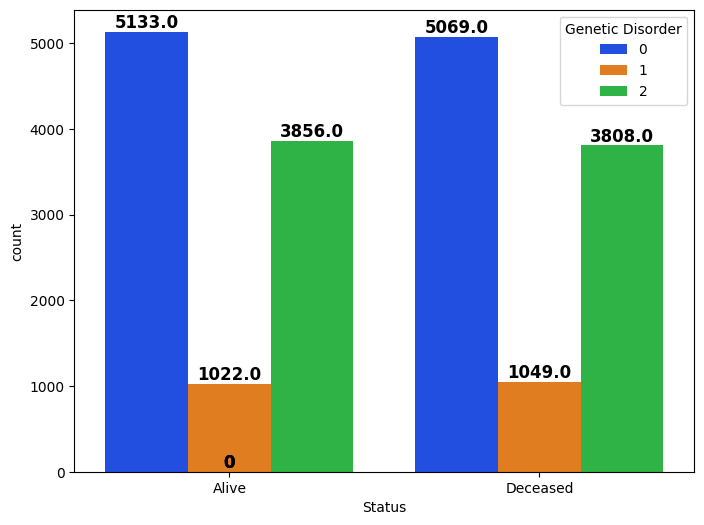

In [89]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Status", data=Dataset, hue="Genetic Disorder", palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [90]:
Dataset["Status"].isnull().sum()

0

In [91]:
Dataset["Status"].unique()

array(['Alive', 'Deceased'], dtype=object)

**Respiratory Rate (breaths/min)**

In [92]:
Dataset["Respiratory Rate (breaths/min)"]

0        Normal (30-60)
2        Normal (30-60)
3             Tachypnea
4             Tachypnea
5                   NaN
              ...      
22077               NaN
22078    Normal (30-60)
22079    Normal (30-60)
22080         Tachypnea
22082    Normal (30-60)
Name: Respiratory Rate (breaths/min), Length: 19937, dtype: object

In [93]:
Dataset["Respiratory Rate (breaths/min)"].value_counts()

Respiratory Rate (breaths/min)
Normal (30-60)    9115
Tachypnea         8996
Name: count, dtype: int64

<ipython-input-94-57767446b5c2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Respiratory Rate (breaths/min)", data=Dataset, palette="bright")


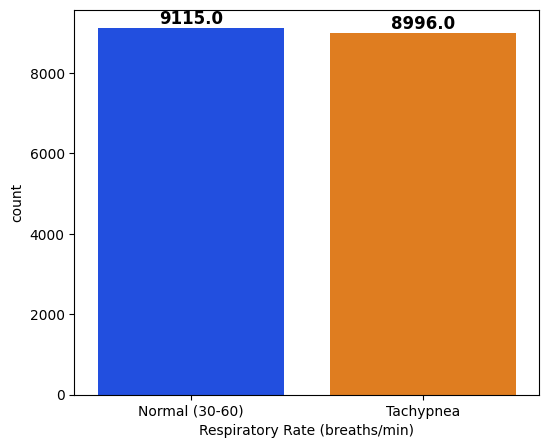

In [94]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Respiratory Rate (breaths/min)", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

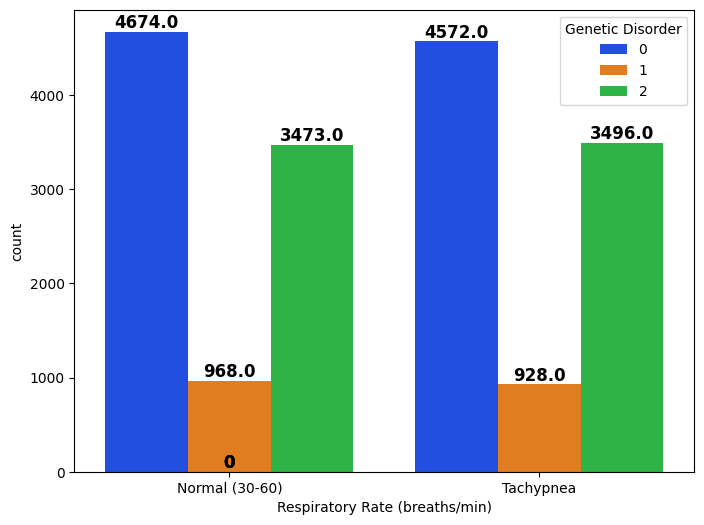

In [95]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Respiratory Rate (breaths/min)", data=Dataset, hue="Genetic Disorder", palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [96]:
Dataset["Respiratory Rate (breaths/min)"].unique()

array(['Normal (30-60)', 'Tachypnea', nan], dtype=object)

In [97]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Respiratory Rate (breaths/min)')

In [98]:
Dataset["Respiratory Rate (breaths/min)"].unique()

array(['Normal (30-60)', 'Tachypnea'], dtype=object)

<ipython-input-99-57767446b5c2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Respiratory Rate (breaths/min)", data=Dataset, palette="bright")


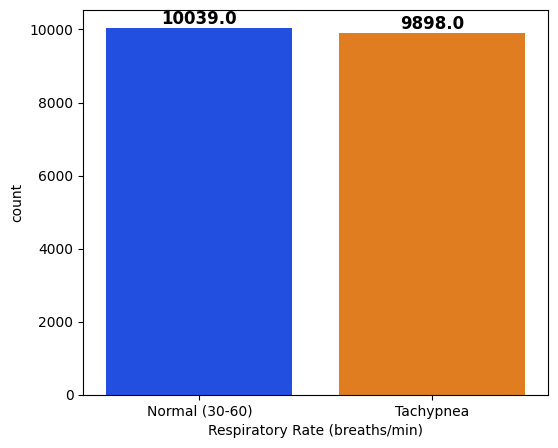

In [99]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Respiratory Rate (breaths/min)", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

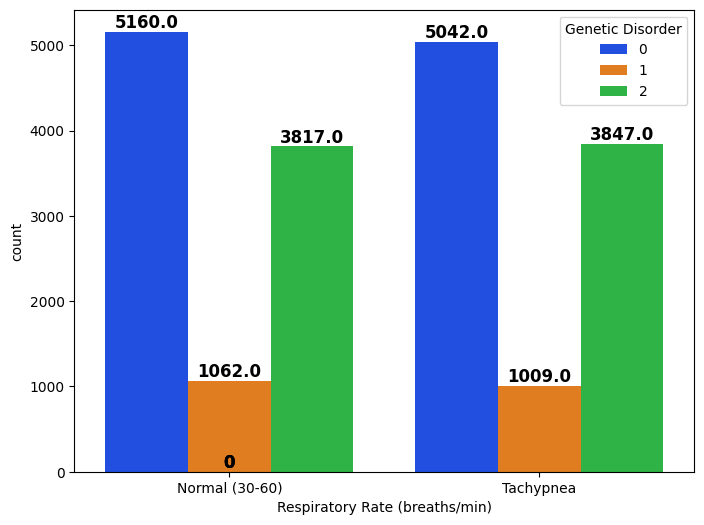

In [100]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Respiratory Rate (breaths/min)", data=Dataset, hue="Genetic Disorder", palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Heart Rate (rates/min**

In [101]:
Dataset["Heart Rate (rates/min"]

0             Normal
2        Tachycardia
3             Normal
4        Tachycardia
5             Normal
            ...     
22077         Normal
22078    Tachycardia
22079         Normal
22080         Normal
22082         Normal
Name: Heart Rate (rates/min, Length: 19937, dtype: object

In [102]:
Dataset["Heart Rate (rates/min"].value_counts()

Heart Rate (rates/min
Normal         9247
Tachycardia    8885
Name: count, dtype: int64

<ipython-input-103-3227f190c961>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Heart Rate (rates/min", data=Dataset, palette="bright")


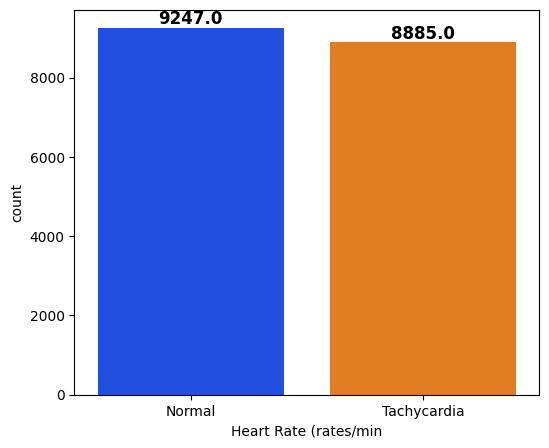

In [103]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Heart Rate (rates/min", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

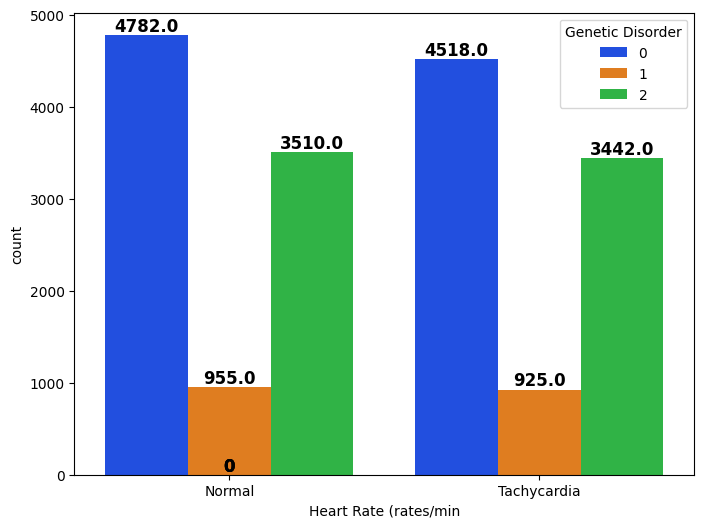

In [104]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Heart Rate (rates/min", data=Dataset, hue="Genetic Disorder", palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [105]:
Dataset["Heart Rate (rates/min"].unique()

array(['Normal', 'Tachycardia', nan], dtype=object)

In [106]:
Dataset["Heart Rate (rates/min"].isnull().sum()

1805

In [107]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Heart Rate (rates/min')

In [108]:
Dataset["Heart Rate (rates/min"].unique()

array(['Normal', 'Tachycardia'], dtype=object)

In [109]:
Dataset["Heart Rate (rates/min"].isnull().sum()

0

<ipython-input-110-3227f190c961>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Heart Rate (rates/min", data=Dataset, palette="bright")


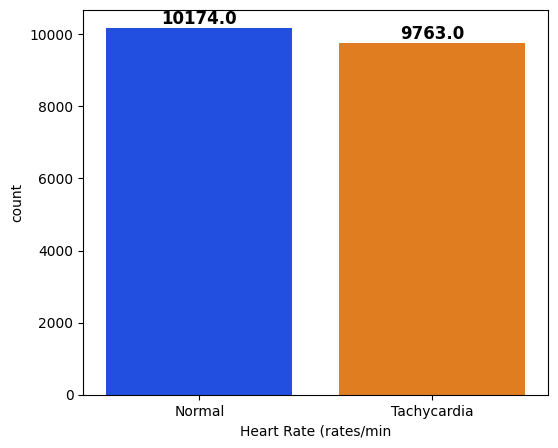

In [110]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Heart Rate (rates/min", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

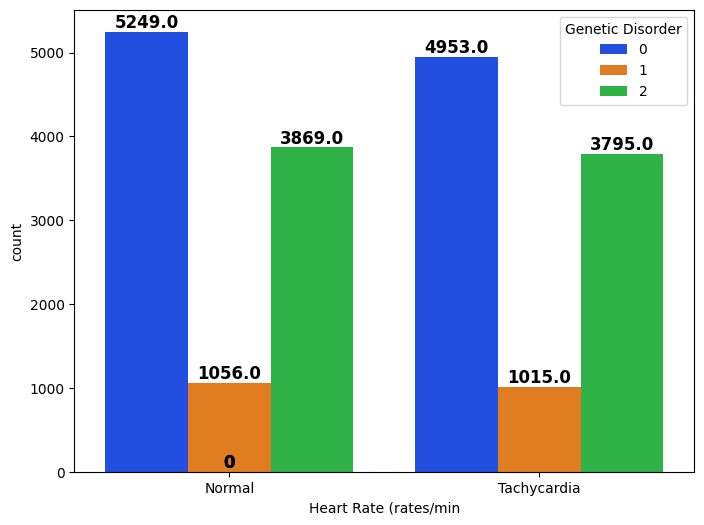

In [111]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Heart Rate (rates/min", data=Dataset, hue="Genetic Disorder", palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Test 1, Test 2, Test 3, Test 4, Test 5**

<ipython-input-112-f1818c2f7896>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Test 1", data=Dataset, palette="bright")


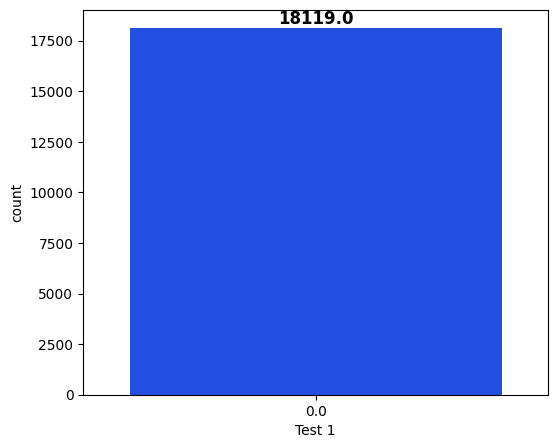

In [112]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Test 1", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

<ipython-input-113-8d8c4454bd9d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Test 2", data=Dataset, palette="bright")


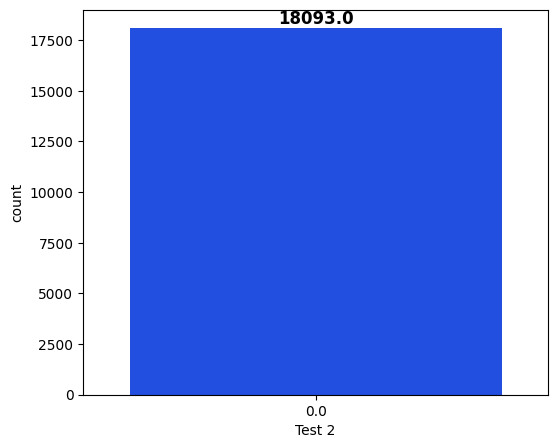

In [113]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Test 2", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

<ipython-input-114-775fb3e01e96>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Test 3", data=Dataset, palette="bright")


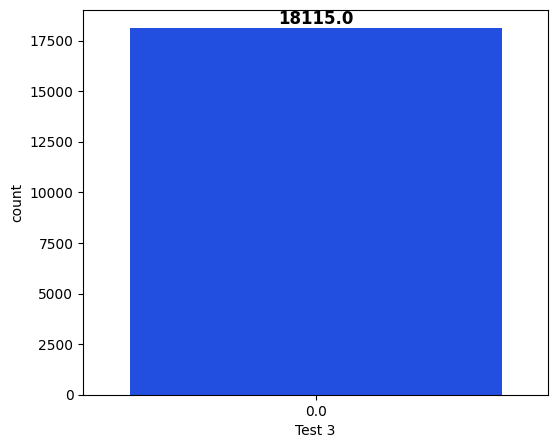

In [114]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Test 3", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

<ipython-input-115-760b70308fae>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Test 4", data=Dataset, palette="bright")


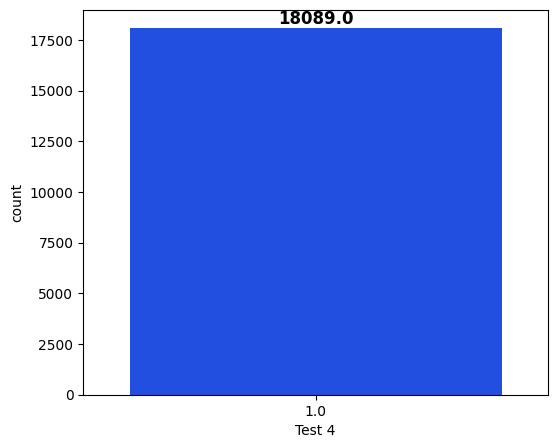

In [115]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Test 4", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

<ipython-input-116-bf79f93e60c7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Test 5", data=Dataset, palette="bright")


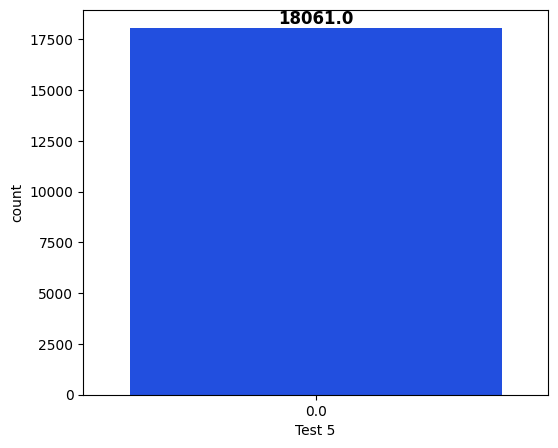

In [116]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Test 5", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Parental consent**

In [117]:
Dataset["Parental consent"]

0        Yes
2        Yes
3        Yes
4        NaN
5        Yes
        ... 
22077    Yes
22078    Yes
22079    NaN
22080    Yes
22082    Yes
Name: Parental consent, Length: 19937, dtype: object

In [118]:
Dataset["Parental consent"].value_counts()

Parental consent
Yes    18118
Name: count, dtype: int64

In [119]:
Dataset["Parental consent"].unique()

array(['Yes', nan], dtype=object)

In [120]:
Dataset["Parental consent"].isnull().sum()

1819

<ipython-input-121-a128148c91ca>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Parental consent", data=Dataset, palette="bright")


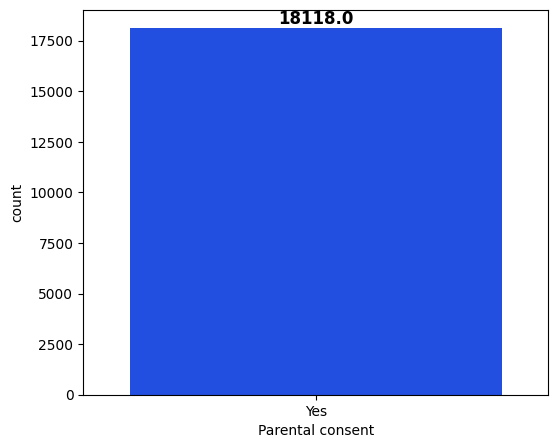

In [121]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Parental consent", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

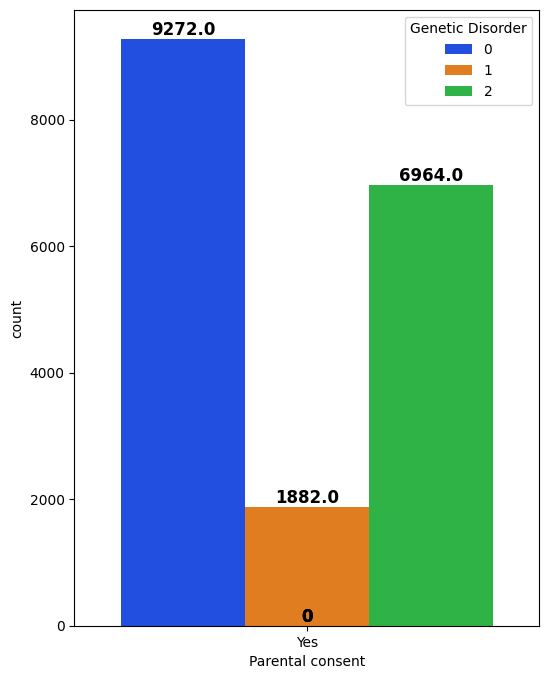

In [122]:
plt.figure(figsize=(6, 8))

ax = sns.countplot(x="Parental consent", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [123]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Parental consent')

In [124]:
Dataset["Parental consent"].unique()

array(['Yes'], dtype=object)

In [125]:
Dataset["Parental consent"].isnull().sum()

0

<ipython-input-126-a128148c91ca>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Parental consent", data=Dataset, palette="bright")


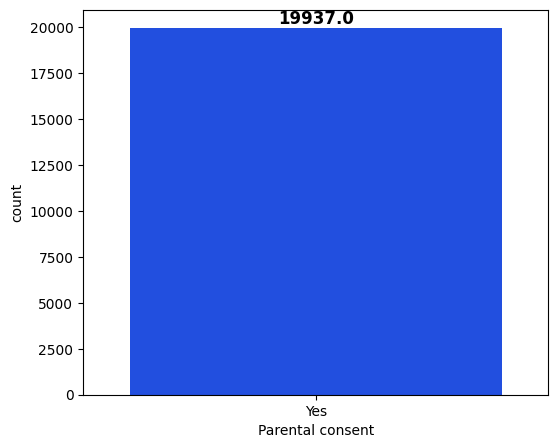

In [126]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Parental consent", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

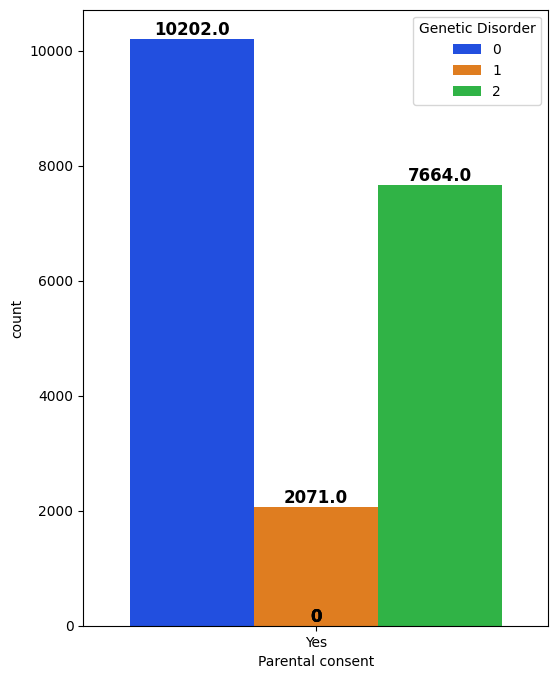

In [127]:
plt.figure(figsize=(6, 8))

ax = sns.countplot(x="Parental consent", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [128]:
Dataset = Dataset.drop(columns=["Test 1" , "Test 2", "Test 3", "Test 4", "Test 5", "Parental consent"])

**Follow-up**

In [129]:
Dataset["Follow-up"]

0        High
2         Low
3        High
4         Low
5         Low
         ... 
22077     NaN
22078    High
22079    High
22080    High
22082    High
Name: Follow-up, Length: 19937, dtype: object

In [130]:
Dataset["Follow-up"].value_counts()

Follow-up
Low     9129
High    8946
Name: count, dtype: int64

In [131]:
Dataset["Follow-up"].unique()

array(['High', 'Low', nan], dtype=object)

In [132]:
Dataset["Follow-up"].isnull().sum()

1862

<ipython-input-133-4f2c03c810aa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Follow-up", data=Dataset, palette="bright")


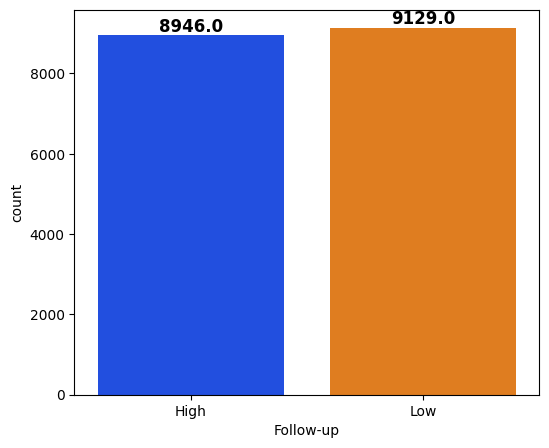

In [133]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Follow-up", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

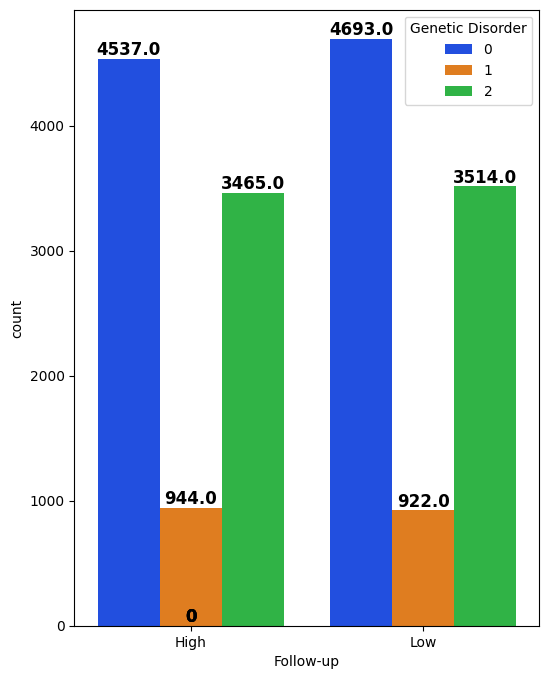

In [134]:
plt.figure(figsize=(6, 8))

ax = sns.countplot(x="Follow-up", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [135]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Follow-up')

In [136]:
Dataset["Follow-up"].unique()

array(['High', 'Low'], dtype=object)

In [137]:
Dataset["Follow-up"].isnull().sum()

0

<ipython-input-138-4f2c03c810aa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Follow-up", data=Dataset, palette="bright")


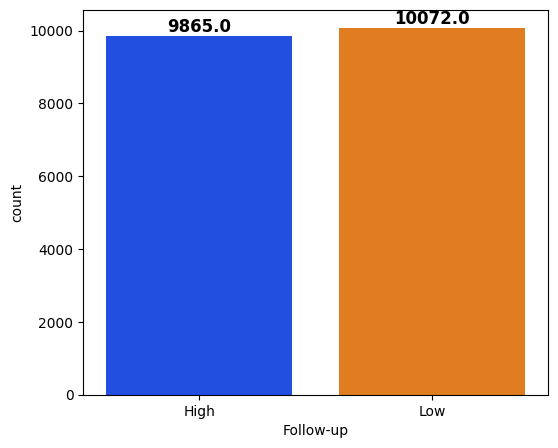

In [138]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Follow-up", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

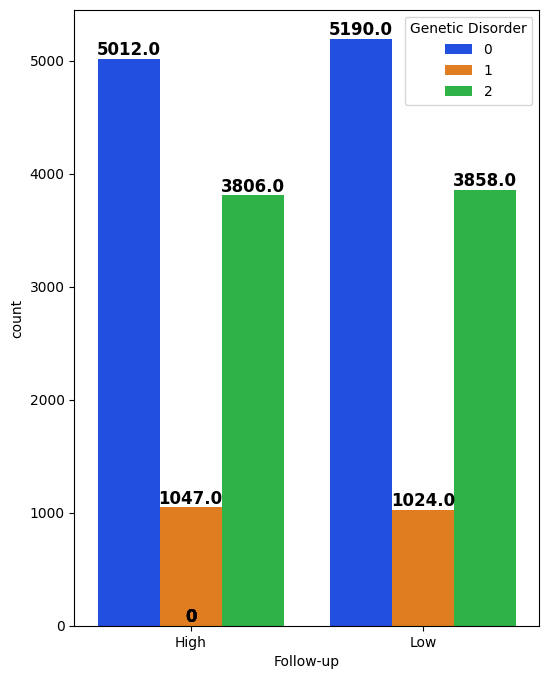

In [139]:
plt.figure(figsize=(6, 8))

ax = sns.countplot(x="Follow-up", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Gender**

In [140]:
Dataset["Gender"]

0              NaN
2              NaN
3             Male
4             Male
5           Female
           ...    
22077    Ambiguous
22078       Female
22079    Ambiguous
22080         Male
22082       Female
Name: Gender, Length: 19937, dtype: object

In [141]:
Dataset["Gender"].value_counts()

Gender
Ambiguous    6068
Male         6059
Female       5966
Name: count, dtype: int64

In [142]:
Dataset["Gender"].unique()

array([nan, 'Male', 'Female', 'Ambiguous'], dtype=object)

In [143]:
Dataset["Gender"].isnull().sum()

1844

<ipython-input-144-ca0057de1f69>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Gender", data=Dataset, palette="bright")


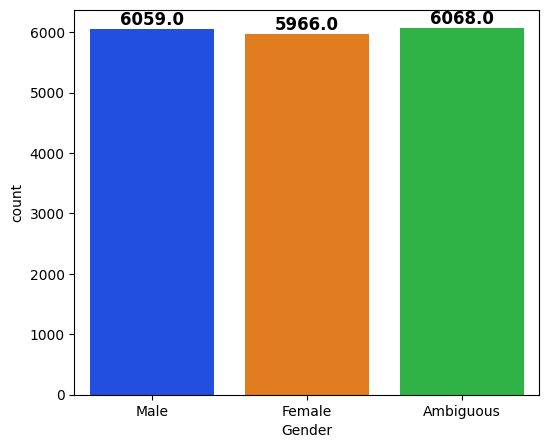

In [144]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Gender", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

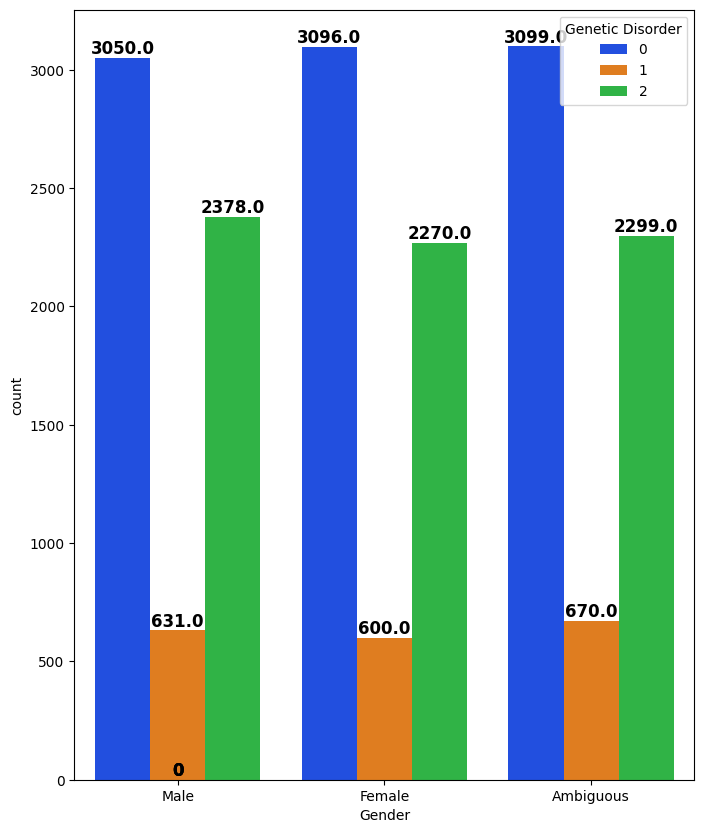

In [145]:
plt.figure(figsize=(8, 10))

ax = sns.countplot(x="Gender", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [146]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Gender')

In [147]:
Dataset["Gender"].unique()

array(['Male', 'Female', 'Ambiguous'], dtype=object)

In [148]:
Dataset["Gender"].isnull().sum()

0

<ipython-input-149-ca0057de1f69>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Gender", data=Dataset, palette="bright")


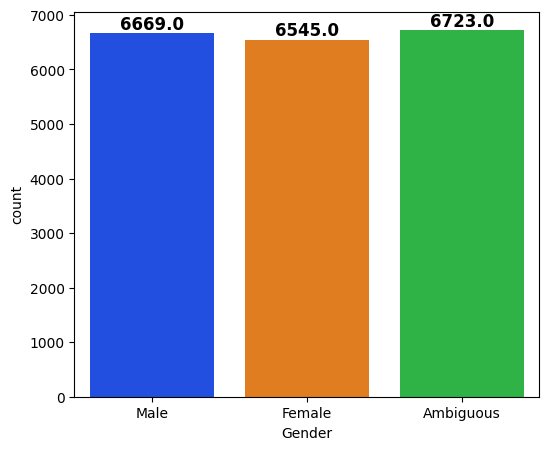

In [149]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Gender", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

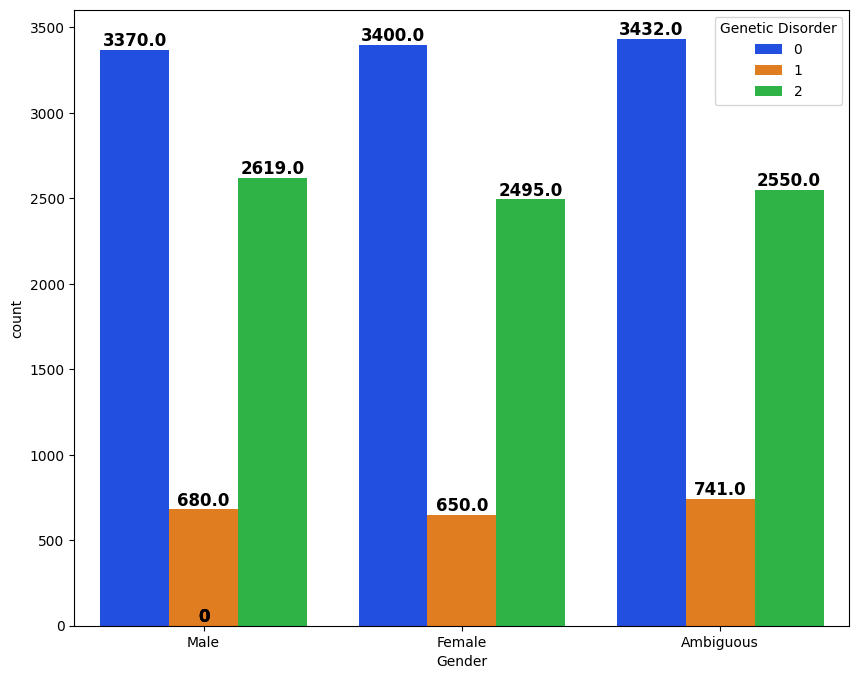

In [150]:
plt.figure(figsize=(10, 8))

ax = sns.countplot(x="Gender", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Birth asphyxia**

In [151]:
Dataset["Birth asphyxia"]

0                  NaN
2            No record
3        Not available
4        Not available
5        Not available
             ...      
22077        No record
22078               No
22079               No
22080               No
22082              Yes
Name: Birth asphyxia, Length: 19937, dtype: object

In [152]:
Dataset["Birth asphyxia"].value_counts()

Birth asphyxia
Yes              4641
No record        4520
Not available    4518
No               4410
Name: count, dtype: int64

In [153]:
Dataset["Birth asphyxia"].unique()

array([nan, 'No record', 'Not available', 'Yes', 'No'], dtype=object)

In [154]:
Dataset["Birth asphyxia"].isnull().sum()

1848

<ipython-input-155-566163f8c7f6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Birth asphyxia", data=Dataset, palette="bright")


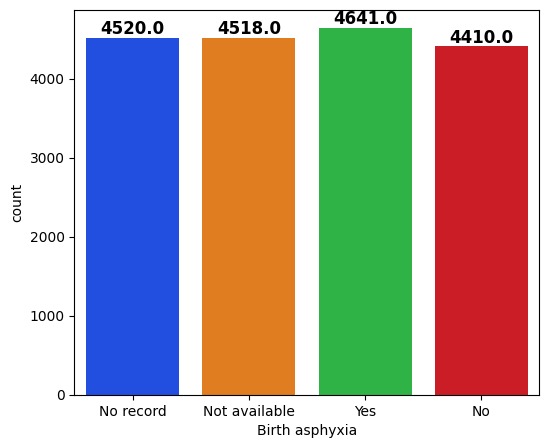

In [155]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Birth asphyxia", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

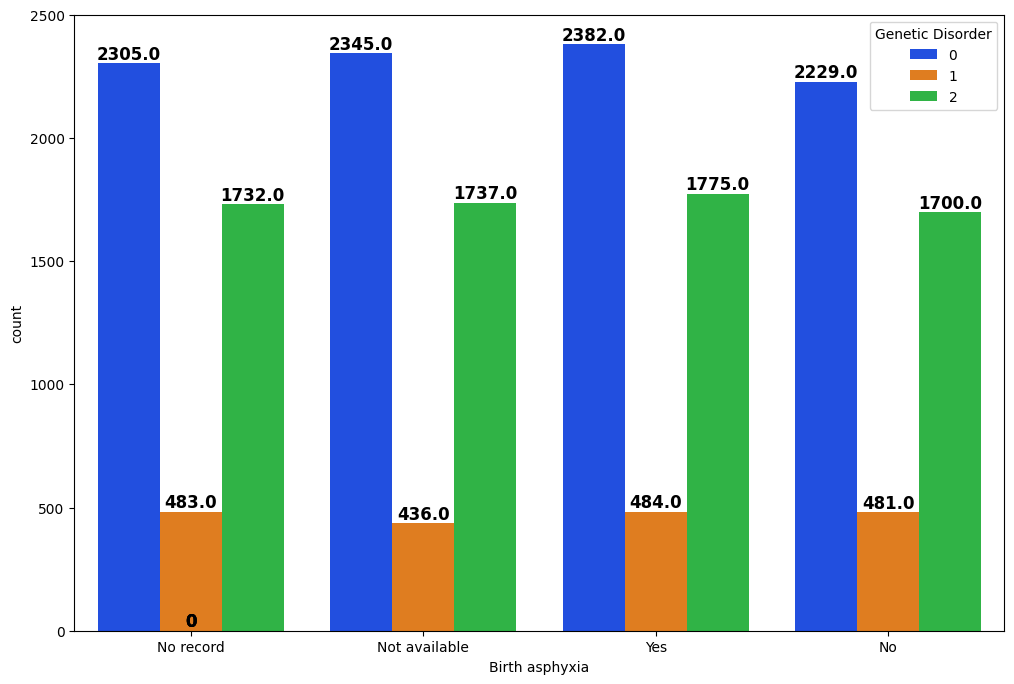

In [156]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(x="Birth asphyxia", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [157]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Birth asphyxia')

<ipython-input-158-566163f8c7f6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Birth asphyxia", data=Dataset, palette="bright")


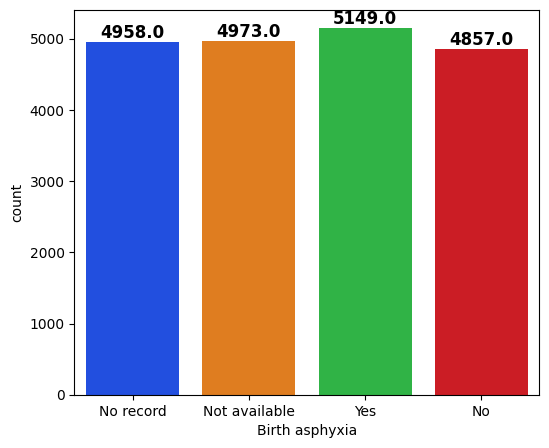

In [158]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Birth asphyxia", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

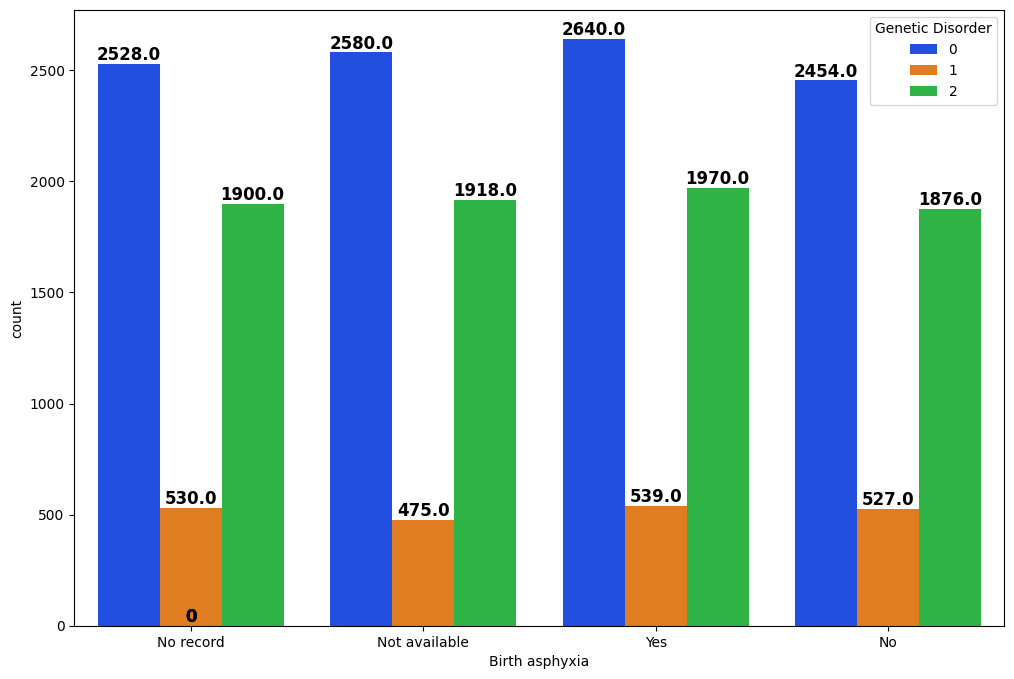

In [159]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(x="Birth asphyxia", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Autopsy shows birth defect (if applicable)**

In [160]:
Dataset["Autopsy shows birth defect (if applicable)"]

0        Not applicable
2        Not applicable
3                    No
4        Not applicable
5                   NaN
              ...      
22077               Yes
22078                No
22079    Not applicable
22080               NaN
22082               NaN
Name: Autopsy shows birth defect (if applicable), Length: 19937, dtype: object

In [161]:
Dataset["Autopsy shows birth defect (if applicable)"].value_counts()

Autopsy shows birth defect (if applicable)
Not applicable    10011
Yes                3082
No                 2909
Name: count, dtype: int64

In [162]:
Dataset["Autopsy shows birth defect (if applicable)"].unique()

array(['Not applicable', 'No', nan, 'Yes'], dtype=object)

In [163]:
Dataset["Autopsy shows birth defect (if applicable)"].isnull().sum()

3935

<ipython-input-164-9c9f3af2c752>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Autopsy shows birth defect (if applicable)", data=Dataset, palette="bright")


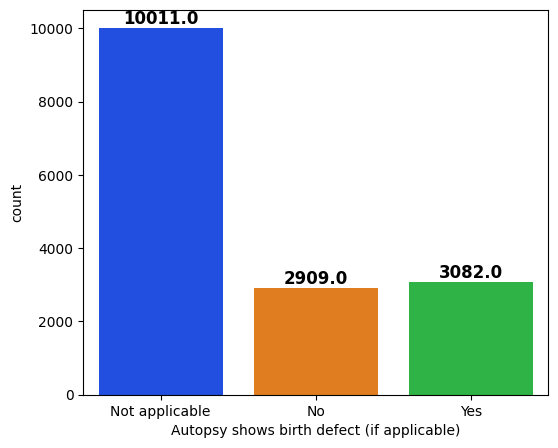

In [164]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Autopsy shows birth defect (if applicable)", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

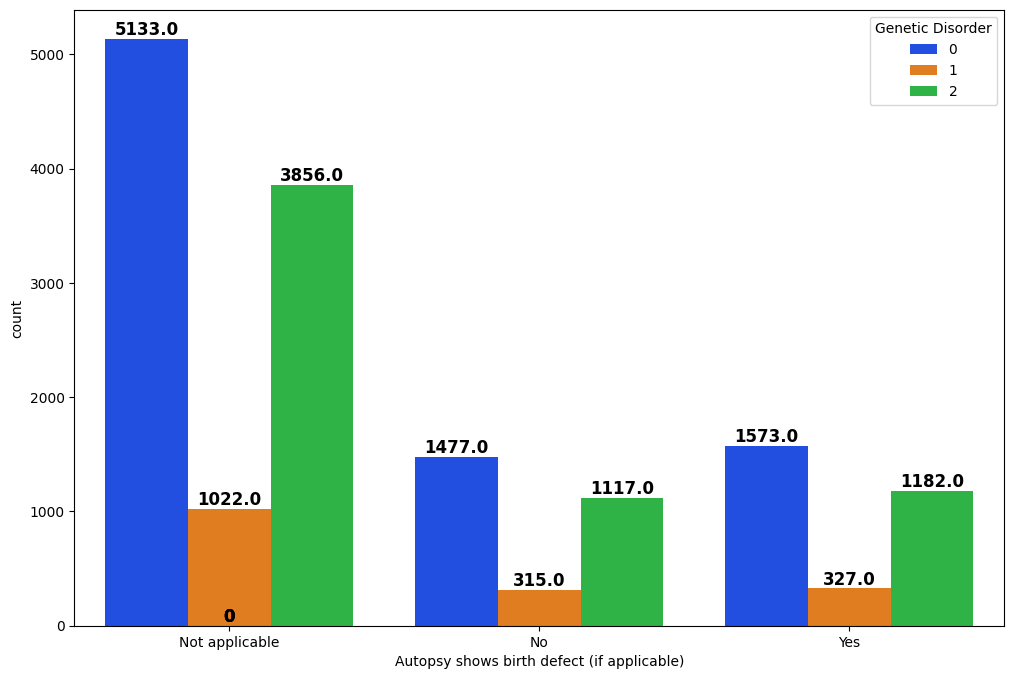

In [165]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(x="Autopsy shows birth defect (if applicable)", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [166]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Autopsy shows birth defect (if applicable)')

In [167]:
Dataset["Autopsy shows birth defect (if applicable)"].unique()

array(['Not applicable', 'No', 'Yes'], dtype=object)

In [168]:
Dataset["Autopsy shows birth defect (if applicable)"].isnull().sum()

0

<ipython-input-169-9c9f3af2c752>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Autopsy shows birth defect (if applicable)", data=Dataset, palette="bright")


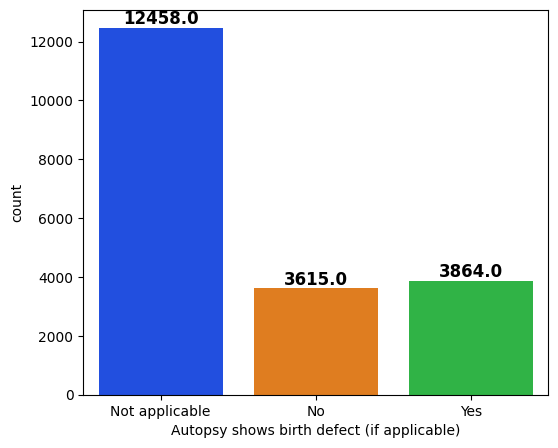

In [169]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Autopsy shows birth defect (if applicable)", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

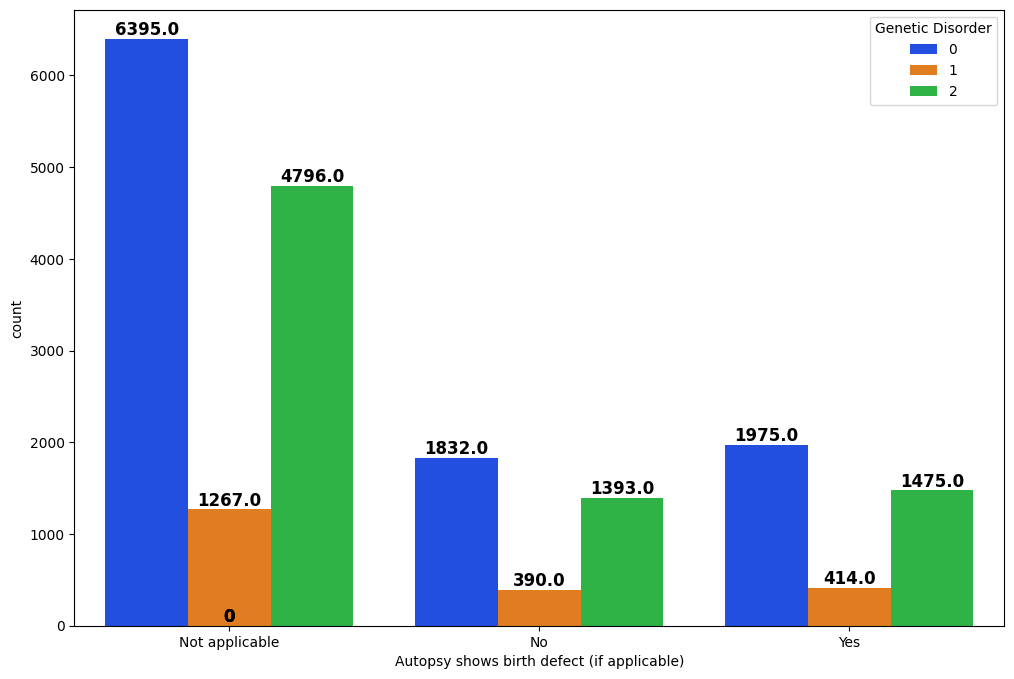

In [170]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(x="Autopsy shows birth defect (if applicable)", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Place of birth**

In [171]:
Dataset["Place of birth"]

0        Institute
2              NaN
3        Institute
4        Institute
5        Institute
           ...    
22077         Home
22078    Institute
22079    Institute
22080         Home
22082    Institute
Name: Place of birth, Length: 19937, dtype: object

In [172]:
Dataset["Place of birth"].value_counts()

Place of birth
Institute    9153
Home         8964
Name: count, dtype: int64

In [173]:
Dataset["Place of birth"].unique()

array(['Institute', nan, 'Home'], dtype=object)

In [174]:
Dataset["Place of birth"].isnull().sum()

1820

<ipython-input-175-83c27d3a1ad1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Place of birth", data=Dataset, palette="bright")


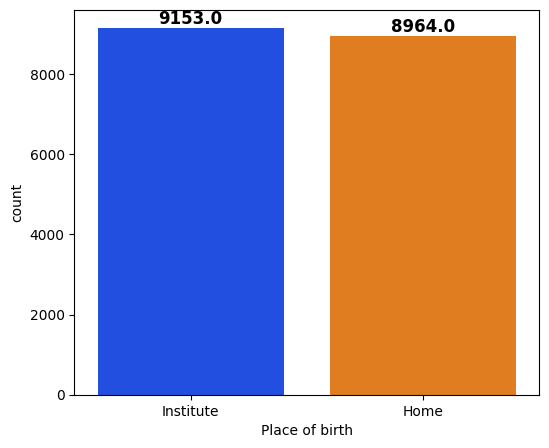

In [175]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Place of birth", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

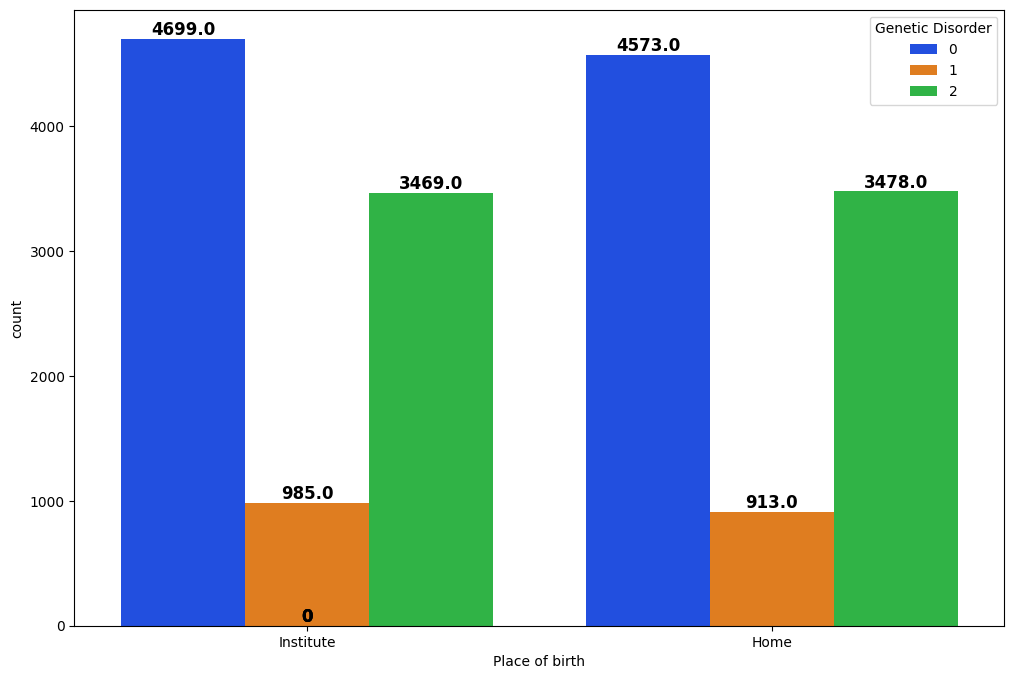

In [176]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(x="Place of birth", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [177]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Place of birth')

In [178]:
Dataset["Place of birth"].unique()

array(['Institute', 'Home'], dtype=object)

In [179]:
Dataset["Place of birth"].isnull().sum()

0

<ipython-input-180-83c27d3a1ad1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Place of birth", data=Dataset, palette="bright")


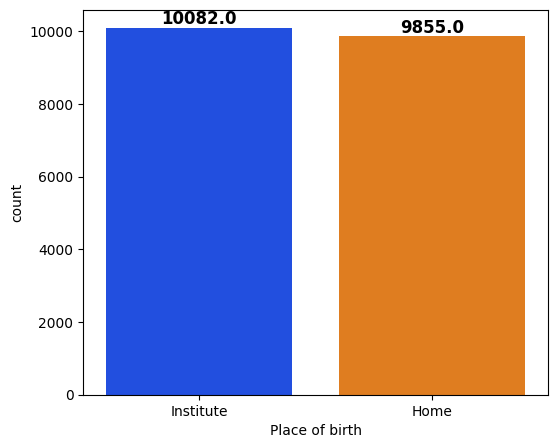

In [180]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Place of birth", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

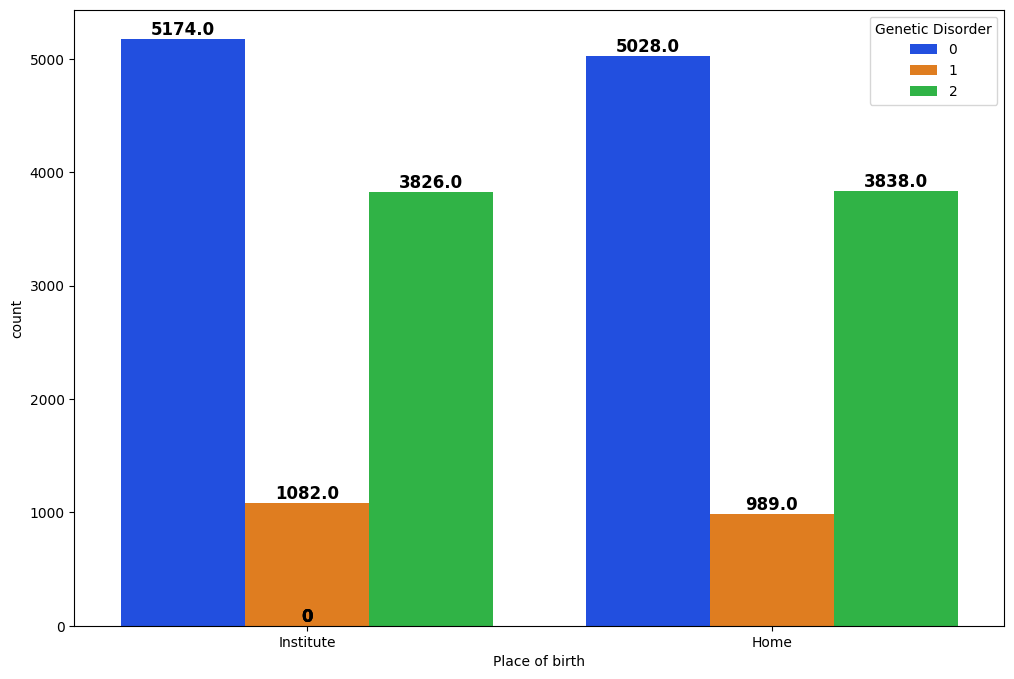

In [181]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(x="Place of birth", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Folic acid details (peri-conceptional)**

In [182]:
Dataset["Folic acid details (peri-conceptional)"]

0         No
2        Yes
3         No
4         No
5         No
        ... 
22077    Yes
22078    NaN
22079    Yes
22080     No
22082    Yes
Name: Folic acid details (peri-conceptional), Length: 19937, dtype: object

In [183]:
Dataset["Folic acid details (peri-conceptional)"].value_counts()

Folic acid details (peri-conceptional)
Yes    9173
No     8950
Name: count, dtype: int64

In [184]:
Dataset["Folic acid details (peri-conceptional)"].unique()

array(['No', 'Yes', nan], dtype=object)

In [185]:
Dataset["Folic acid details (peri-conceptional)"].isnull().sum()

1814

<ipython-input-186-b044d40e9834>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Folic acid details (peri-conceptional)", data=Dataset, palette="bright")


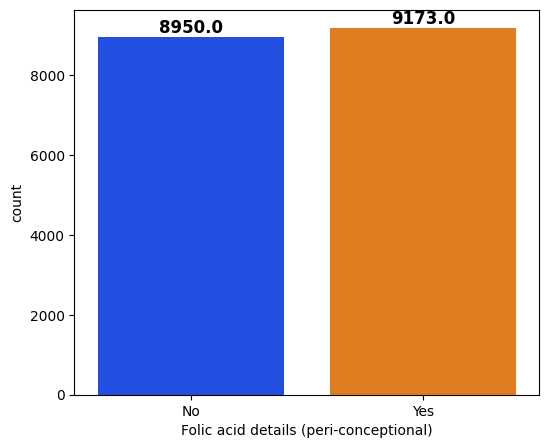

In [186]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Folic acid details (peri-conceptional)", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

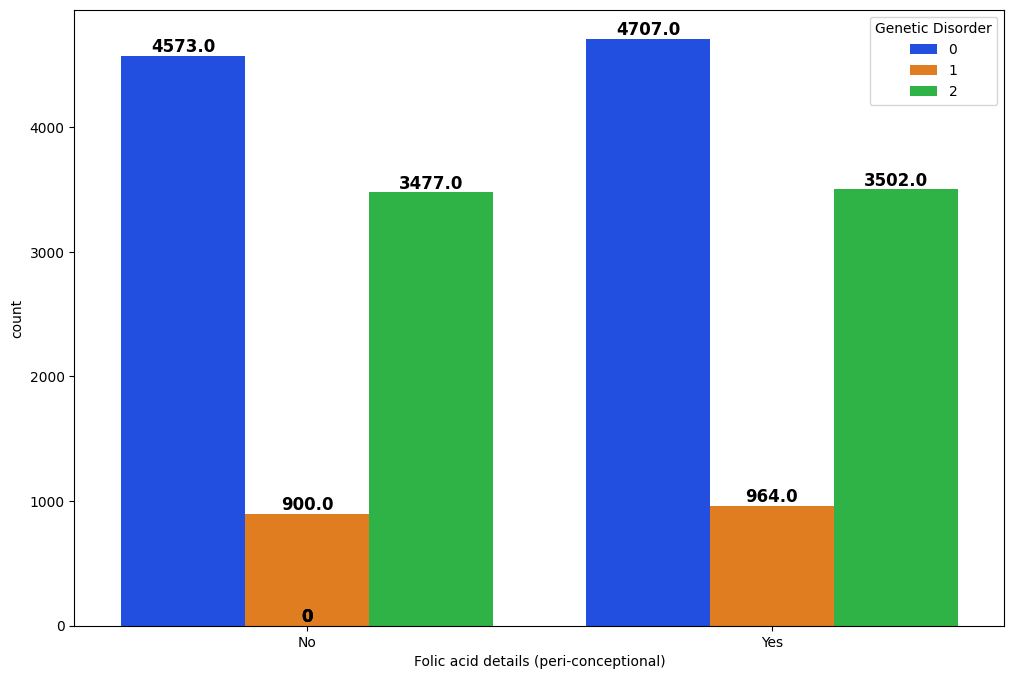

In [187]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(x="Folic acid details (peri-conceptional)", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [188]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Folic acid details (peri-conceptional)')

In [189]:
Dataset["Folic acid details (peri-conceptional)"].unique()

array(['No', 'Yes'], dtype=object)

In [190]:
Dataset["Folic acid details (peri-conceptional)"].isnull().sum()

0

<ipython-input-191-b044d40e9834>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Folic acid details (peri-conceptional)", data=Dataset, palette="bright")


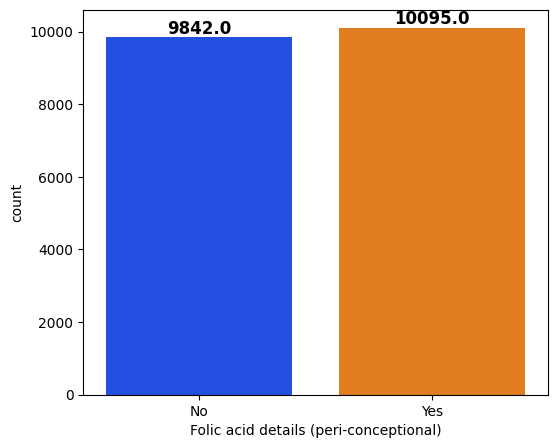

In [191]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Folic acid details (peri-conceptional)", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

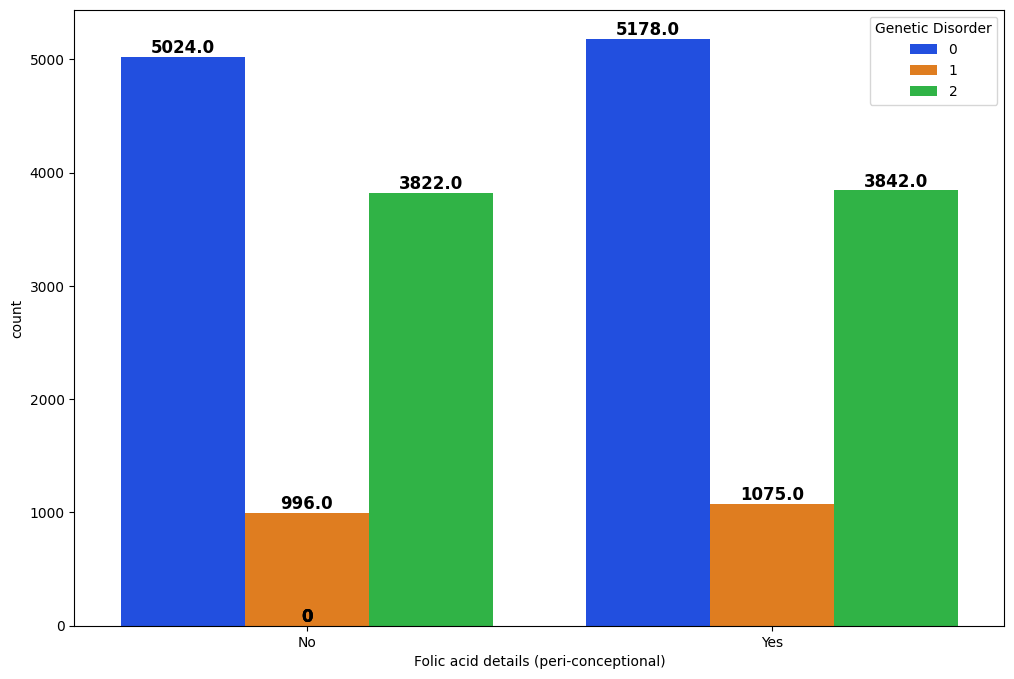

In [192]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(x="Folic acid details (peri-conceptional)", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**H/O serious maternal illness, H/O radiation exposure (x-ray), H/O substance abuse, Assisted conception IVF/ART, History of anomalies in previous pregnancies**

In [193]:
Dataset["H/O serious maternal illness"].value_counts()

H/O serious maternal illness
No     9093
Yes    9020
Name: count, dtype: int64

In [194]:
Dataset["H/O radiation exposure (x-ray)"].value_counts()

H/O radiation exposure (x-ray)
Not applicable    4593
Yes               4538
No                4525
-                 4451
Name: count, dtype: int64

In [195]:
Dataset["H/O substance abuse"].value_counts()

H/O substance abuse
No                4601
-                 4547
Yes               4516
Not applicable    4373
Name: count, dtype: int64

In [196]:
Dataset["Assisted conception IVF/ART"].value_counts()

Assisted conception IVF/ART
Yes    9084
No     9006
Name: count, dtype: int64

In [197]:
Dataset["History of anomalies in previous pregnancies"].value_counts()

History of anomalies in previous pregnancies
Yes    9085
No     8959
Name: count, dtype: int64

In [198]:
Dataset["White Blood cell count (thousand per microliter)"].value_counts()

White Blood cell count (thousand per microliter)
3.000000     1213
12.000000    1196
9.857562        1
9.067686        1
9.739904        1
             ... 
5.170352        1
4.383106        1
7.854600        1
4.180118        1
11.188371       1
Name: count, Length: 15681, dtype: int64

In [199]:
# Handle missing value for H/O serious maternal illness
Dataset = impute_categorical_with_proportions_improved(Dataset, 'H/O serious maternal illness')

In [200]:
# Handle missing value for H/O radiation exposure (x-ray)
Dataset = impute_categorical_with_proportions_improved(Dataset, 'H/O radiation exposure (x-ray)')

In [201]:
# Handle missing value for H/O substance abuse
Dataset = impute_categorical_with_proportions_improved(Dataset, 'H/O substance abuse')

In [202]:
# Handle missing value for Assisted conception IVF/ART
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Assisted conception IVF/ART')

In [203]:
# Handle missing value for History of anomalies in previous pregnancies
Dataset = impute_categorical_with_proportions_improved(Dataset, 'History of anomalies in previous pregnancies')

In [204]:
# Handle missing value for White Blood cell count (thousand per microliter)
Dataset = impute_numeric_with_kde(Dataset, 'White Blood cell count (thousand per microliter)', valid_range=(3, 12))

**No. of previous abortion**

In [205]:
Dataset["No. of previous abortion"]

0        NaN
2        4.0
3        1.0
4        4.0
5        0.0
        ... 
22077    NaN
22078    3.0
22079    2.0
22080    2.0
22082    4.0
Name: No. of previous abortion, Length: 19937, dtype: float64

In [206]:
Dataset["No. of previous abortion"].value_counts()

No. of previous abortion
2.0    3736
4.0    3618
0.0    3615
1.0    3576
3.0    3564
Name: count, dtype: int64

In [207]:
Dataset["No. of previous abortion"].unique()

array([nan,  4.,  1.,  0.,  3.,  2.])

In [208]:
Dataset["No. of previous abortion"].isnull().sum()

1828

<ipython-input-209-a067b2a427db>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="No. of previous abortion", data=Dataset, palette="bright")


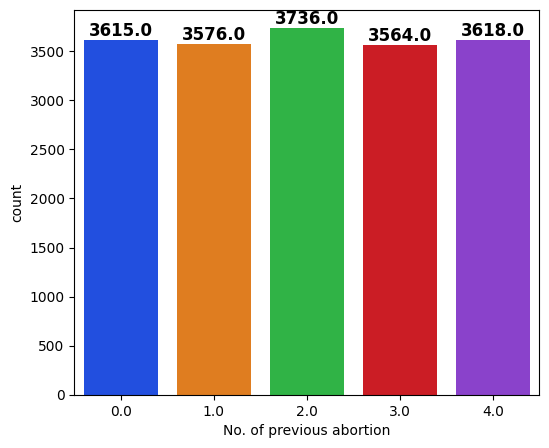

In [209]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="No. of previous abortion", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

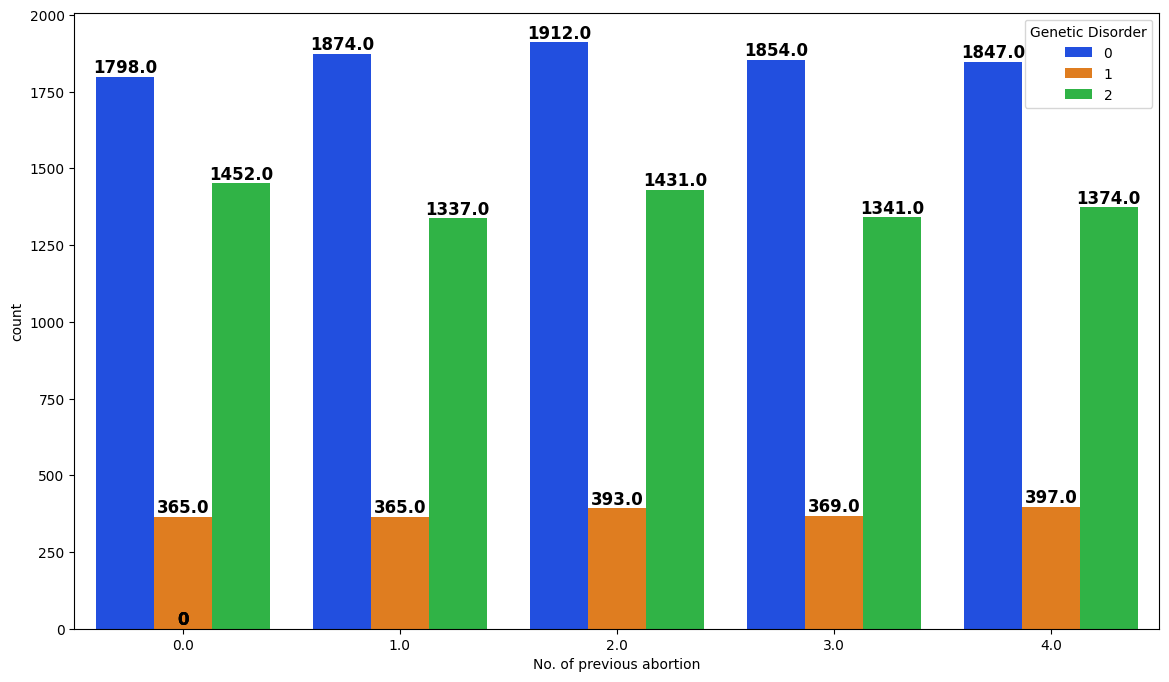

In [210]:
plt.figure(figsize=(14, 8))

ax = sns.countplot(x="No. of previous abortion", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [211]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'No. of previous abortion')

In [212]:
Dataset["No. of previous abortion"].unique()

array([4., 1., 0., 3., 2.])

In [213]:
Dataset["No. of previous abortion"].isnull().sum()

0

<ipython-input-214-a067b2a427db>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="No. of previous abortion", data=Dataset, palette="bright")


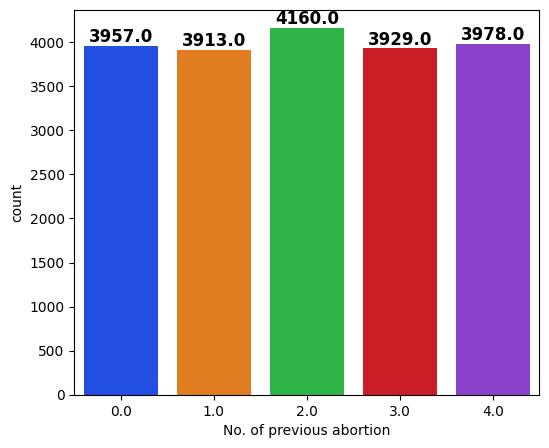

In [214]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="No. of previous abortion", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

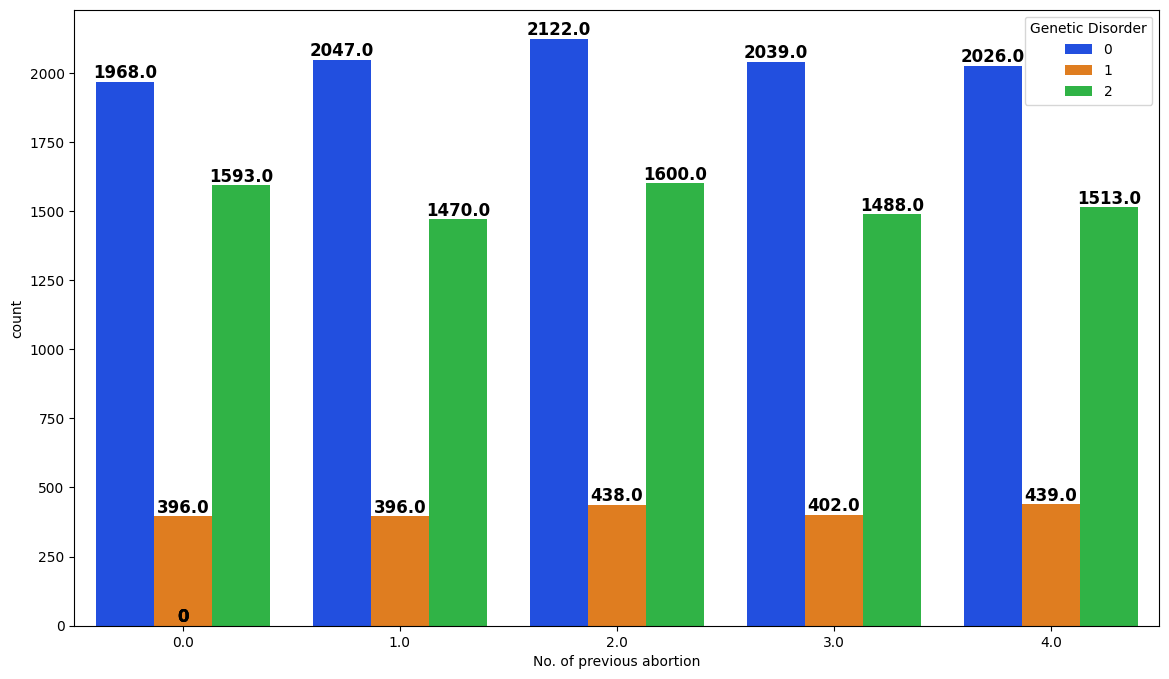

In [215]:
plt.figure(figsize=(14, 8))

ax = sns.countplot(x="No. of previous abortion", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Birth defects**

In [216]:
Dataset["Birth defects"]

0             NaN
2        Singular
3        Singular
4        Multiple
5        Multiple
           ...   
22077         NaN
22078    Multiple
22079    Multiple
22080    Singular
22082    Singular
Name: Birth defects, Length: 19937, dtype: object

In [217]:
Dataset["Birth defects"].value_counts()

Birth defects
Multiple    9056
Singular    9042
Name: count, dtype: int64

In [218]:
Dataset["Birth defects"].unique()

array([nan, 'Singular', 'Multiple'], dtype=object)

In [219]:
Dataset["Birth defects"].isnull().sum()

1839

<ipython-input-220-472c4fc425fb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Birth defects", data=Dataset, palette="bright")


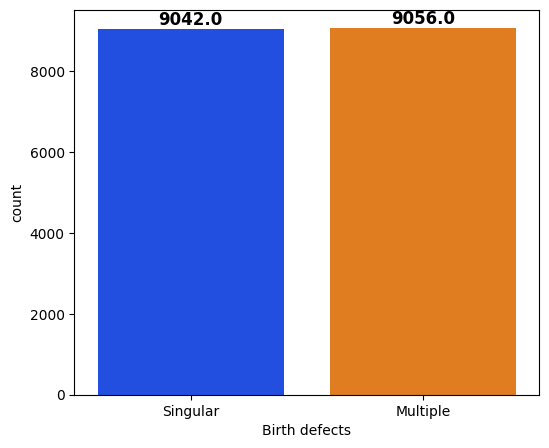

In [220]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Birth defects", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

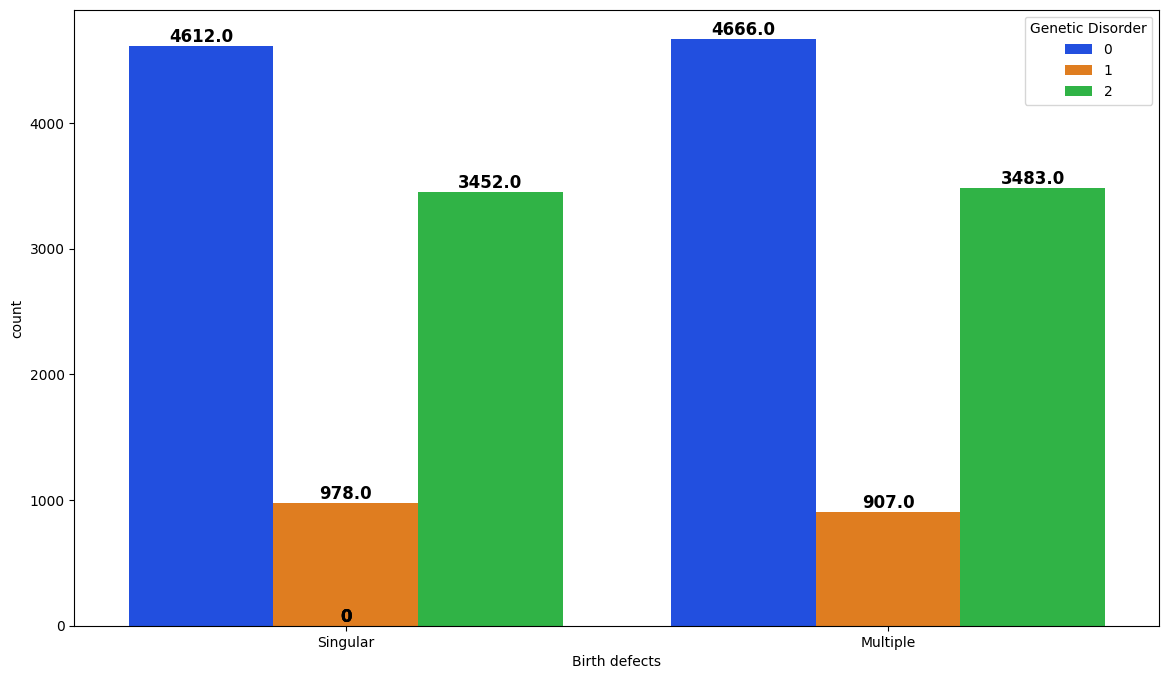

In [221]:
plt.figure(figsize=(14, 8))

ax = sns.countplot(x="Birth defects", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [222]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Birth defects')

In [223]:
Dataset["Birth defects"].unique()

array(['Multiple', 'Singular'], dtype=object)

In [224]:
Dataset["Birth defects"].isnull().sum()

0

<ipython-input-225-472c4fc425fb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Birth defects", data=Dataset, palette="bright")


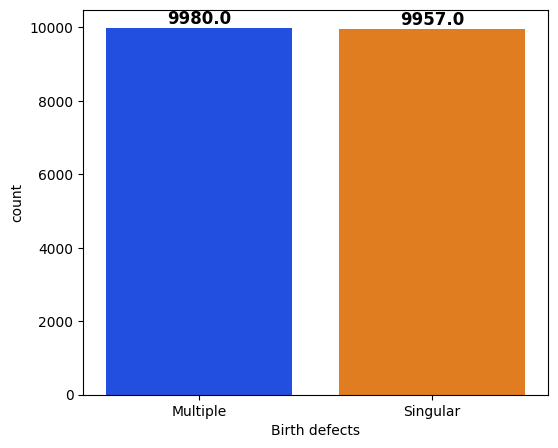

In [225]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Birth defects", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

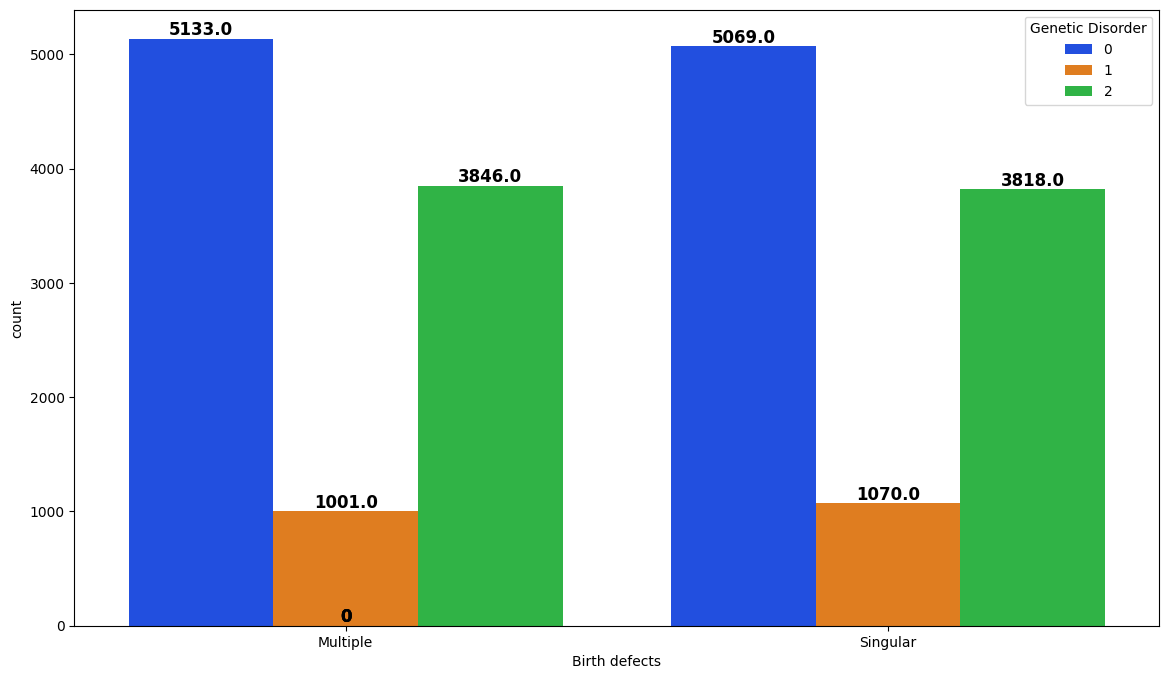

In [226]:
plt.figure(figsize=(14, 8))

ax = sns.countplot(x="Birth defects", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Blood test result**

In [227]:
Dataset["Blood test result"]

0                      NaN
2                   normal
3             inconclusive
4                      NaN
5                   normal
               ...        
22077    slightly abnormal
22078         inconclusive
22079         inconclusive
22080               normal
22082               normal
Name: Blood test result, Length: 19937, dtype: object

In [228]:
Dataset["Blood test result"].value_counts()

Blood test result
slightly abnormal    4644
normal               4521
inconclusive         4511
abnormal             4428
Name: count, dtype: int64

In [229]:
Dataset["Blood test result"].unique()

array([nan, 'normal', 'inconclusive', 'slightly abnormal', 'abnormal'],
      dtype=object)

In [230]:
Dataset["Blood test result"].isnull().sum()

1833

<ipython-input-231-99c7072dc96c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Blood test result", data=Dataset, palette="bright")


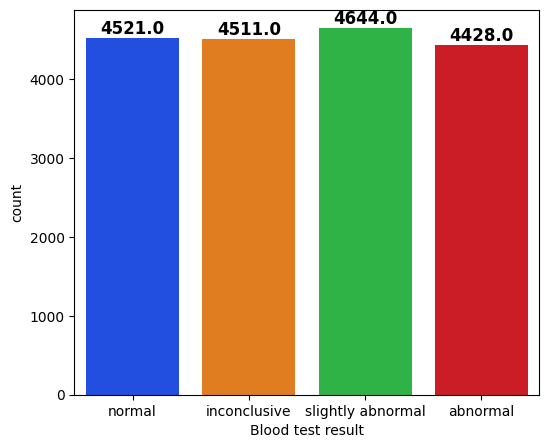

In [231]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Blood test result", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

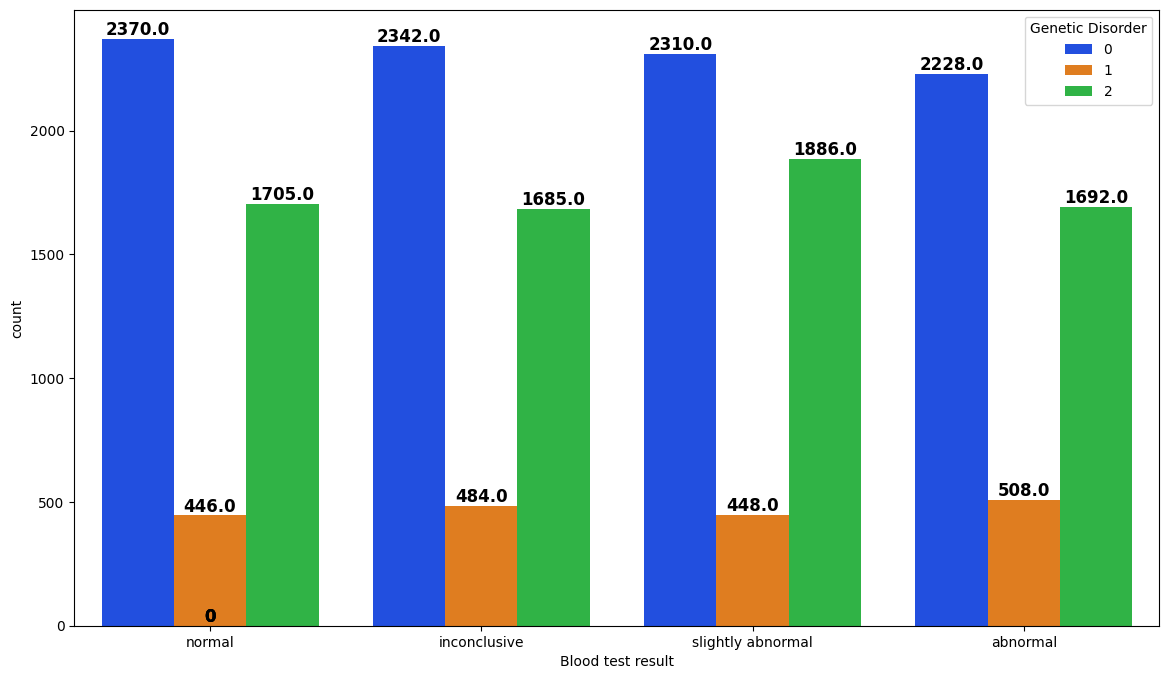

In [232]:
plt.figure(figsize=(14, 8))

ax = sns.countplot(x="Blood test result", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

In [233]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Blood test result')

In [234]:
Dataset["Blood test result"].isnull().sum()

0

In [235]:
Dataset["Blood test result"].unique()

array(['normal', 'inconclusive', 'slightly abnormal', 'abnormal'],
      dtype=object)

<ipython-input-236-99c7072dc96c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Blood test result", data=Dataset, palette="bright")


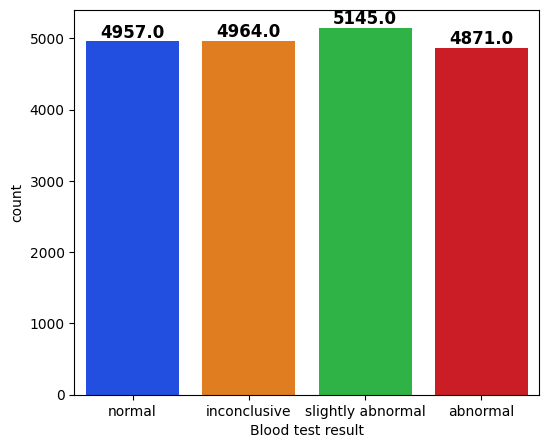

In [236]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(x="Blood test result", data=Dataset, palette="bright")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

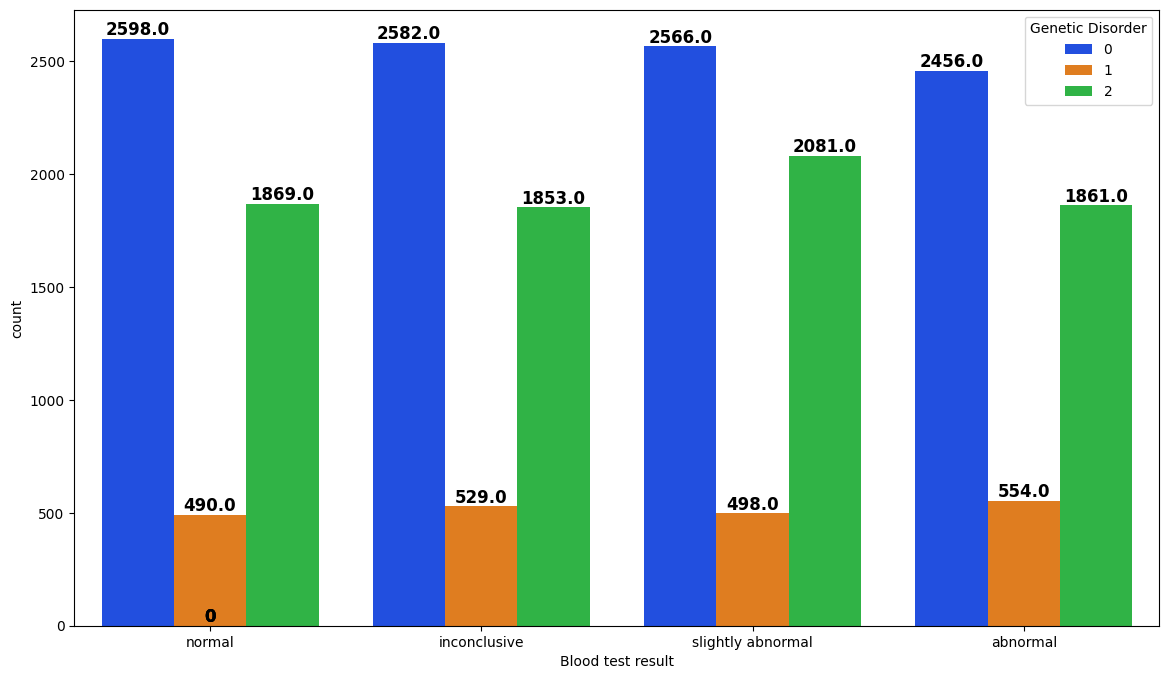

In [237]:
plt.figure(figsize=(14, 8))

ax = sns.countplot(x="Blood test result", data=Dataset, palette="bright", hue="Genetic Disorder")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

**Symptom 1, Symptom 2, Symptom 3, Symptom 4, Symptom 5**

In [238]:
Dataset["Symptom 1"]

0        1.0
2        0.0
3        0.0
4        0.0
5        1.0
        ... 
22077    NaN
22078    0.0
22079    1.0
22080    0.0
22082    1.0
Name: Symptom 1, Length: 19937, dtype: float64

In [239]:
Dataset["Symptom 1"].value_counts()

Symptom 1
1.0    10691
0.0     7402
Name: count, dtype: int64

In [240]:
Dataset["Symptom 1"].unique()

array([ 1.,  0., nan])

In [241]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Symptom 1')

In [242]:
Dataset["Symptom 1"].isnull().sum()

0

In [243]:
Dataset["Symptom 2"]

0        1.0
2        1.0
3        0.0
4        0.0
5        0.0
        ... 
22077    1.0
22078    0.0
22079    1.0
22080    0.0
22082    0.0
Name: Symptom 2, Length: 19937, dtype: float64

In [244]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Symptom 2')

In [245]:
Dataset["Symptom 3"]

0        1.0
2        1.0
3        1.0
4        0.0
5        0.0
        ... 
22077    0.0
22078    1.0
22079    1.0
22080    0.0
22082    1.0
Name: Symptom 3, Length: 19937, dtype: float64

In [246]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Symptom 3')

In [247]:
Dataset["Symptom 4"]

0        1.0
2        1.0
3        0.0
4        0.0
5        1.0
        ... 
22077    0.0
22078    0.0
22079    1.0
22080    1.0
22082    1.0
Name: Symptom 4, Length: 19937, dtype: float64

In [248]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Symptom 4')

In [249]:
Dataset["Symptom 5"]

0        1.0
2        1.0
3        0.0
4        NaN
5        0.0
        ... 
22077    0.0
22078    0.0
22079    0.0
22080    NaN
22082    1.0
Name: Symptom 5, Length: 19937, dtype: float64

In [250]:
# Handle missing value
Dataset = impute_categorical_with_proportions_improved(Dataset, 'Symptom 5')

In [251]:
Dataset.isnull().sum()

Patient Age                                         0
Genes in mother's side                              0
Inherited from father                               0
Maternal gene                                       0
Paternal gene                                       0
Blood cell count (mcL)                              0
Status                                              0
Respiratory Rate (breaths/min)                      0
Heart Rate (rates/min                               0
Follow-up                                           0
Gender                                              0
Birth asphyxia                                      0
Autopsy shows birth defect (if applicable)          0
Place of birth                                      0
Folic acid details (peri-conceptional)              0
H/O serious maternal illness                        0
H/O radiation exposure (x-ray)                      0
H/O substance abuse                                 0
Assisted conception IVF/ART                         0
History of anomalies in previous pregnancies        0
No. of previous abortion                            0
Birth defects                                       0
White Blood cell count (thousand per microliter)    0
Blood test result                                   0
Symptom 1                                           0
Symptom 2                                           0
Symptom 3                                           0
Symptom 4                                           0
Symptom 5                                           0
Genetic Disorder                                    0
dtype: int64

In [252]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19937 entries, 0 to 22082
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Age                                       19937 non-null  float64
 1   Genes in mother's side                            19937 non-null  object 
 2   Inherited from father                             19937 non-null  object 
 3   Maternal gene                                     19937 non-null  object 
 4   Paternal gene                                     19937 non-null  object 
 5   Blood cell count (mcL)                            19937 non-null  float64
 6   Status                                            19937 non-null  object 
 7   Respiratory Rate (breaths/min)                    19937 non-null  object 
 8   Heart Rate (rates/min                             19937 non-null  object 
 9   Follow-up             

### **Preprocessing**

---



In [253]:
from sklearn.preprocessing import LabelEncoder

In [254]:
label_encoder = LabelEncoder()

In [255]:
Dataset.head()

Patient Age Genes in mother's side Inherited from father Maternal gene  \
0          2.0                    Yes                    No           Yes   
2          6.0                    Yes                    No            No   
3         12.0                    Yes                    No           Yes   
4         11.0                    Yes                    No           Yes   
5         14.0                    Yes                    No           Yes   

  Paternal gene  Blood cell count (mcL)    Status  \
0            No                4.760603     Alive   
2            No                4.893297     Alive   
3            No                4.705280  Deceased   
4           Yes                4.720703     Alive   
5            No                5.103188  Deceased   

  Respiratory Rate (breaths/min) Heart Rate (rates/min Follow-up  ...  \
0                 Normal (30-60)                Normal      High  ...   
2                 Normal (30-60)           Tachycardia       Low  ...   
3                      Tachypnea                Normal      High  ...   
4                      Tachypnea           Tachycardia       Low  ...   
5                 Normal (30-60)                Normal       Low  ...   

  No. of previous abortion Birth defects  \
0                      4.0      Multiple   
2                      4.0      Singular   
3                      1.0      Singular   
4                      4.0      Multiple   
5                      0.0      Multiple   

  White Blood cell count (thousand per microliter) Blood test result  \
0                                         9.857562            normal   
2                                        12.000000            normal   
3                                         7.919321      inconclusive   
4                                         4.098210            normal   
5                                        10.272230            normal   

  Symptom 1 Symptom 2 Symptom 3 Symptom 4 Symptom 5 Genetic Disorder  
0       1.0       1.0       1.0       1.0       1.0                0  
2       0.0       1.0       1.0       1.0       1.0                1  
3       0.0       0.0       1.0       0.0       0.0                0  
4       0.0       0.0       0.0       0.0       1.0                1  
5       1.0       0.0       0.0       1.0       0.0                2  

[5 rows x 30 columns]

In [256]:
categorical_cols = Dataset.select_dtypes(include=['object']).columns

In [257]:
for col in categorical_cols:
    Dataset[col] = label_encoder.fit_transform(Dataset[col])

In [258]:
Dataset.head()

Patient Age  Genes in mother's side  Inherited from father  Maternal gene  \
0          2.0                       1                      0              1   
2          6.0                       1                      0              0   
3         12.0                       1                      0              1   
4         11.0                       1                      0              1   
5         14.0                       1                      0              1   

   Paternal gene  Blood cell count (mcL)  Status  \
0              0                4.760603       0   
2              0                4.893297       0   
3              0                4.705280       1   
4              1                4.720703       0   
5              0                5.103188       1   

   Respiratory Rate (breaths/min)  Heart Rate (rates/min  Follow-up  ...  \
0                               0                      0          0  ...   
2                               0                      1          1  ...   
3                               1                      0          0  ...   
4                               1                      1          1  ...   
5                               0                      0          1  ...   

   No. of previous abortion  Birth defects  \
0                       4.0              0   
2                       4.0              1   
3                       1.0              1   
4                       4.0              0   
5                       0.0              0   

   White Blood cell count (thousand per microliter)  Blood test result  \
0                                          9.857562                  2   
2                                         12.000000                  2   
3                                          7.919321                  1   
4                                          4.098210                  2   
5                                         10.272230                  2   

   Symptom 1  Symptom 2  Symptom 3  Symptom 4  Symptom 5  Genetic Disorder  
0        1.0        1.0        1.0        1.0        1.0                 0  
2        0.0        1.0        1.0        1.0        1.0                 1  
3        0.0        0.0        1.0        0.0        0.0                 0  
4        0.0        0.0        0.0        0.0        1.0                 1  
5        1.0        0.0        0.0        1.0        0.0                 2  

[5 rows x 30 columns]

In [259]:
Dataset["Genetic Disorder"].value_counts()

Genetic Disorder
0    10202
2     7664
1     2071
Name: count, dtype: int64

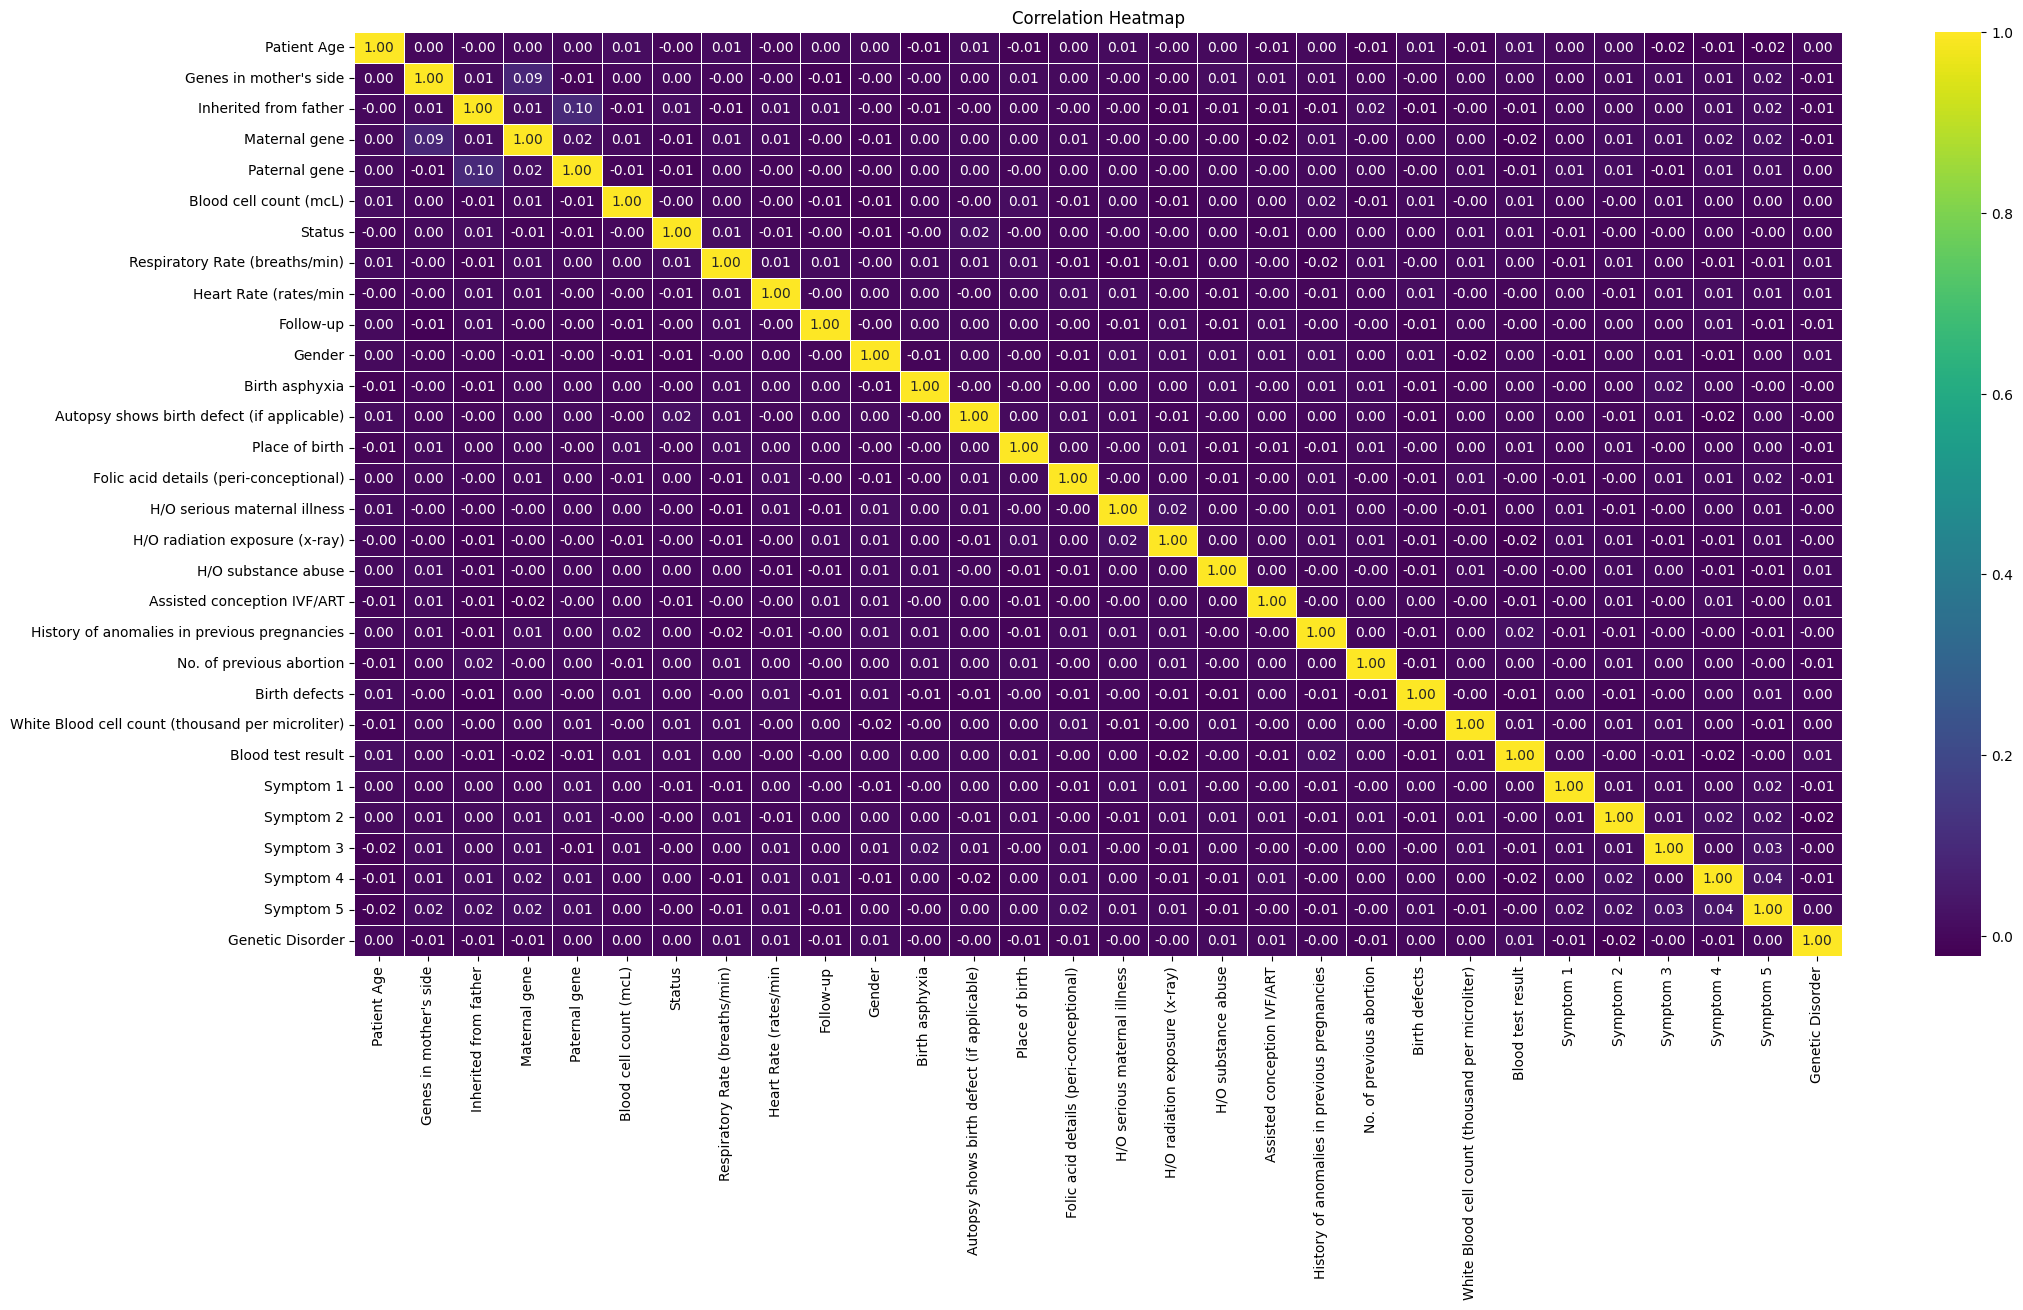

In [260]:
plt.figure(figsize=(24, 12))
sns.heatmap(Dataset.corr(), annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

**Train Test Split**

In [261]:
# Separate features and target
X = Dataset.drop("Genetic Disorder", axis=1)
y = Dataset["Genetic Disorder"]

In [262]:
cat_columns = X.select_dtypes(include=["object", "category"]).columns.tolist()
float_columns = X.select_dtypes(include=["float64"]).columns.tolist()

In [263]:
# Split data (stratified due to imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [265]:
scaler = StandardScaler()
X_train[float_columns] = scaler.fit_transform(X_train[float_columns])
X_test[float_columns] = scaler.transform(X_test[float_columns])

## **Model Train with Categorical Distribution**

---



### **Model 1: CatBoost**

In [987]:
cat_model = CatBoostClassifier(
    iterations=1000, depth=6, learning_rate=0.05, auto_class_weights="Balanced", random_state=42, verbose=100
)

In [988]:
cat_model.fit(X_train, y_train)

0:	learn: 1.0785427	total: 67.6ms	remaining: 1m 7s
100:	learn: 0.7984935	total: 1.33s	remaining: 11.8s
200:	learn: 0.7545962	total: 2.55s	remaining: 10.1s
300:	learn: 0.7180225	total: 3.72s	remaining: 8.64s
400:	learn: 0.6873870	total: 4.89s	remaining: 7.31s
500:	learn: 0.6588350	total: 6.07s	remaining: 6.04s
600:	learn: 0.6328181	total: 7.25s	remaining: 4.81s
700:	learn: 0.6086671	total: 8.58s	remaining: 3.66s
800:	learn: 0.5861265	total: 11.2s	remaining: 2.77s
900:	learn: 0.5663146	total: 12.3s	remaining: 1.35s
999:	learn: 0.5483626	total: 13.5s	remaining: 0us


In [989]:
y_pred_cat = cat_model.predict(X_test)

In [990]:
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66      2041
           1       0.39      0.72      0.50       414
           2       0.52      0.40      0.45      1533

    accuracy                           0.57      3988
   macro avg       0.52      0.59      0.54      3988
weighted avg       0.58      0.57      0.56      3988



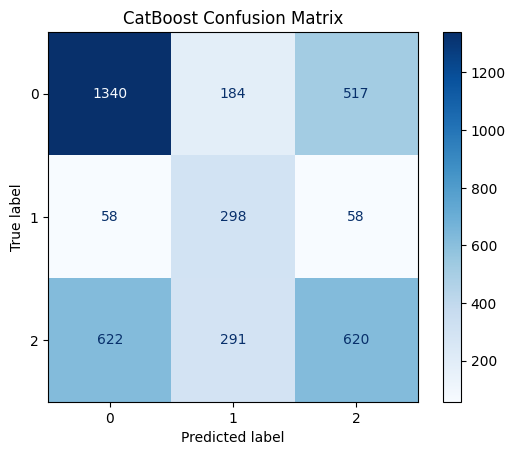

In [991]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap="Blues")
plt.title("CatBoost Confusion Matrix")
plt.show()

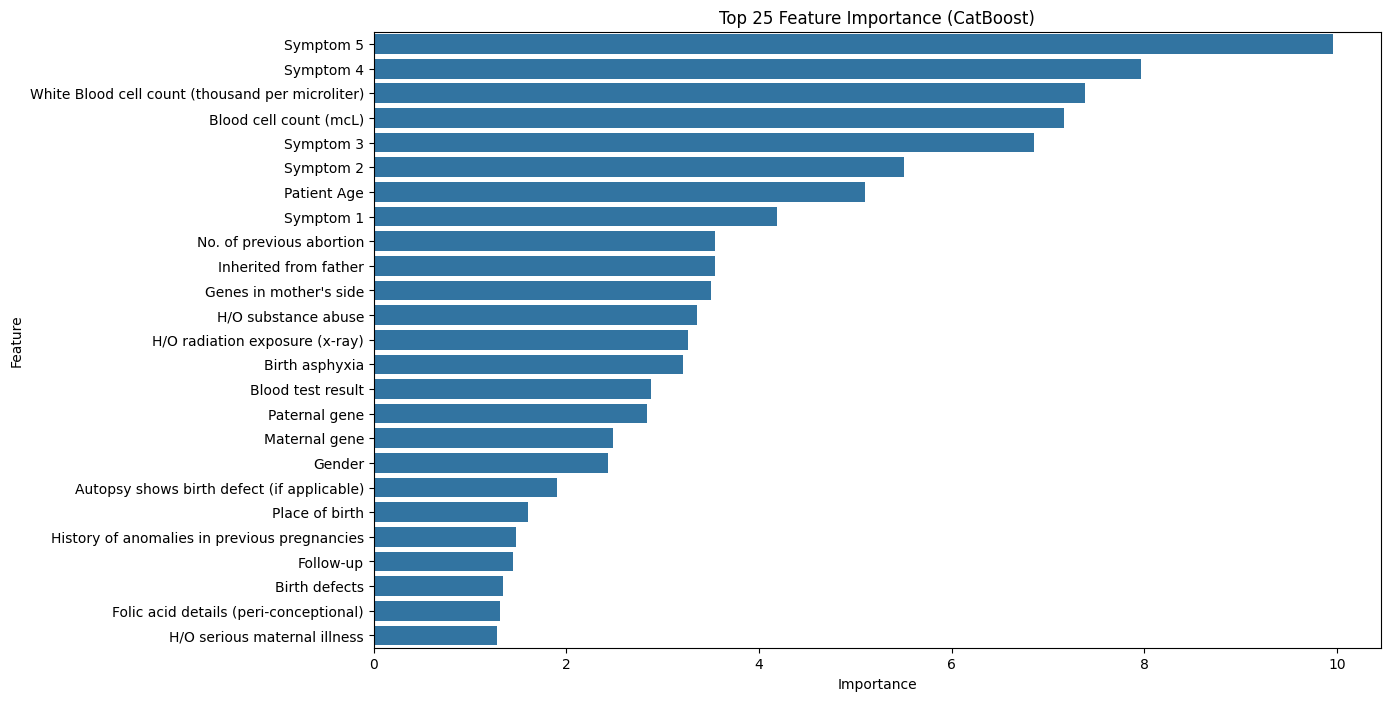

In [992]:
# Feature Importance Plot
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": cat_model.get_feature_importance()})
feature_importance = feature_importance.sort_values("Importance", ascending=False)
plt.figure(figsize=(13, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(25))
plt.title("Top 25 Feature Importance (CatBoost)")
plt.show()

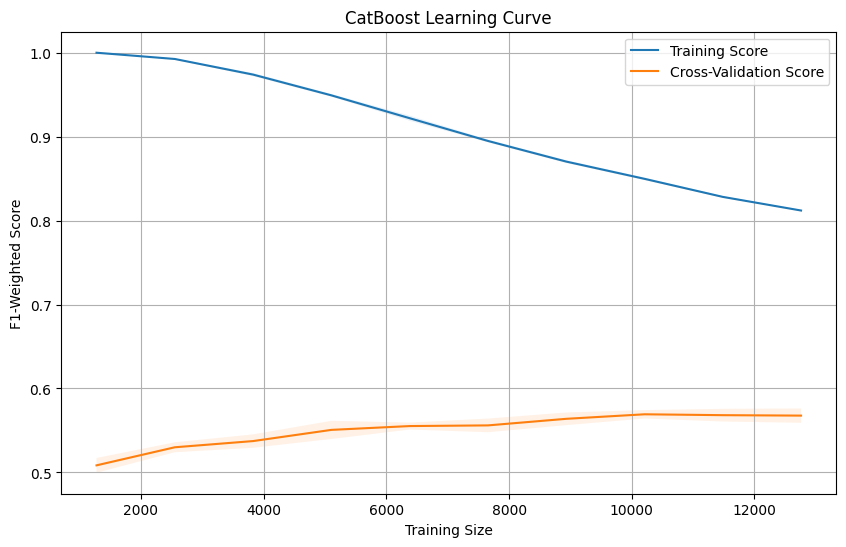

In [993]:
train_sizes, train_scores, test_scores = learning_curve(
    cat_model, X_train, y_train, cv=5, scoring="f1_weighted", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Size")
plt.ylabel("F1-Weighted Score")
plt.title("CatBoost Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

### **Model 2: Random Forest**

In [994]:
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42
)

In [995]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [996]:
y_pred_rf = rf_model.predict(X_test)

In [997]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69      2041
           1       0.38      0.77      0.51       414
           2       0.56      0.31      0.40      1533

    accuracy                           0.57      3988
   macro avg       0.53      0.60      0.53      3988
weighted avg       0.59      0.57      0.56      3988



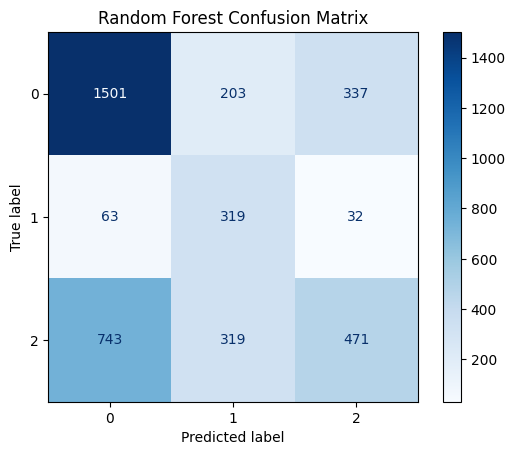

In [998]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

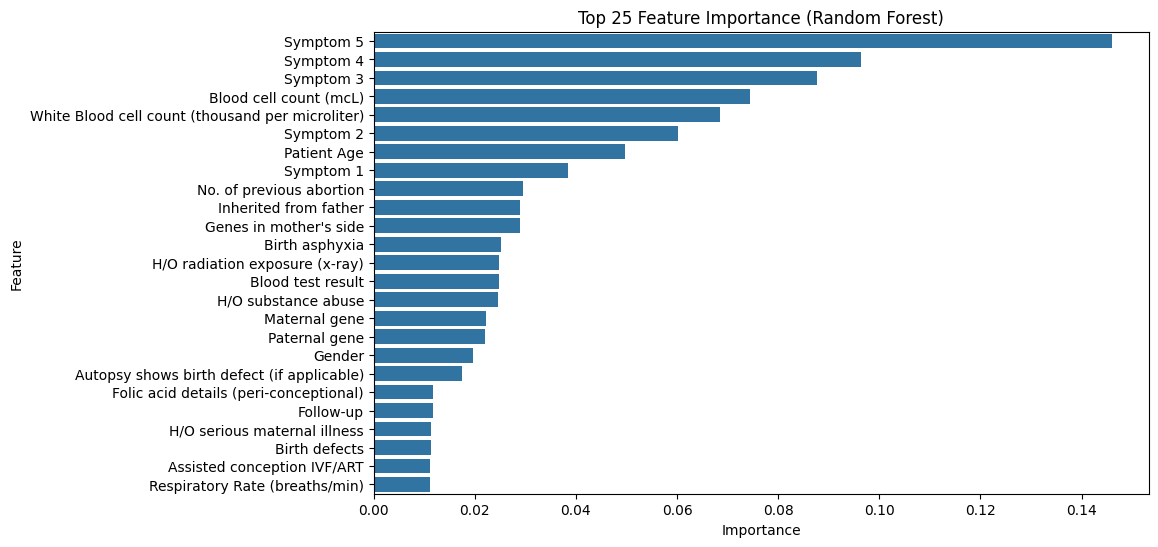

In [999]:
# Feature Importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
feature_importance = feature_importance.sort_values("Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(25))
plt.title("Top 25 Feature Importance (Random Forest)")
plt.show()

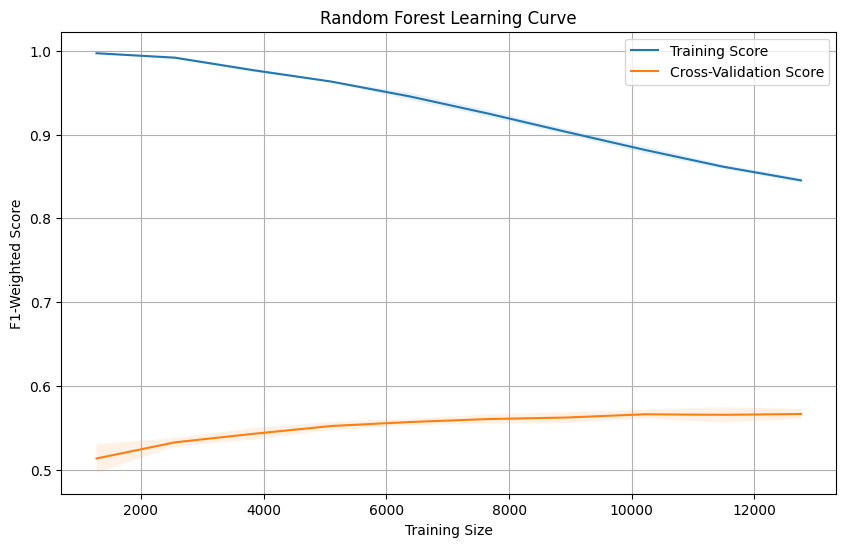

In [1000]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring="f1_weighted", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Size")
plt.ylabel("F1-Weighted Score")
plt.title("Random Forest Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

### **Model 3: XGBoost**

In [1001]:
# Define class weights
class_weights = {0: 1.0, 1: 10_202/2_071, 2: 10_202/7_664}
sample_weights = [class_weights[label] for label in y_train]

In [1002]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.05, subsample=0.8, use_label_encoder=False,
    eval_metric="mlogloss", random_state=42
)

In [1003]:
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:45:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [1004]:
y_pred_xgb = xgb_model.predict(X_test)

In [1005]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      2041
           1       0.37      0.77      0.50       414
           2       0.51      0.38      0.43      1533

    accuracy                           0.55      3988
   macro avg       0.51      0.60      0.53      3988
weighted avg       0.57      0.55      0.55      3988



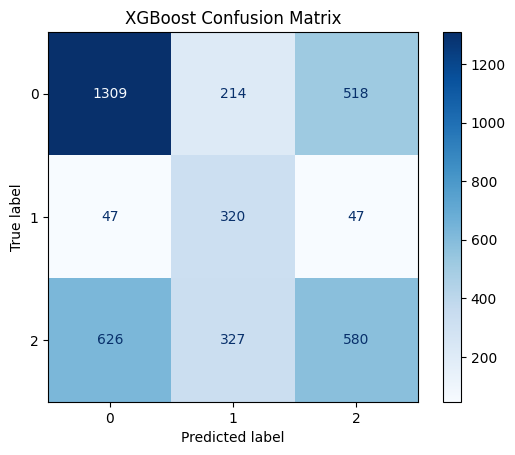

In [1006]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()

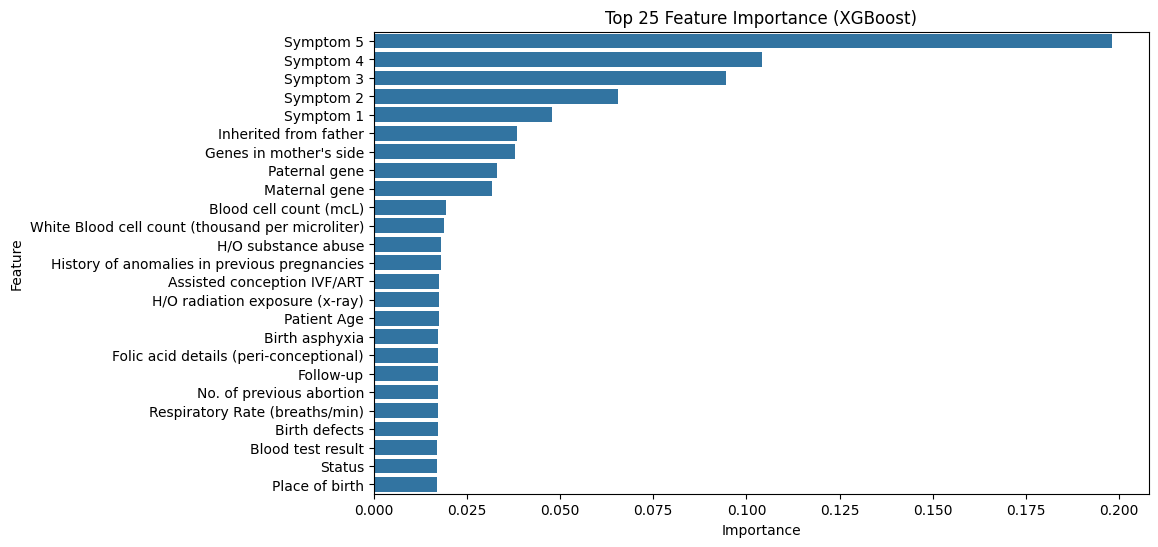

In [1007]:
# Feature Importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values("Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(25))
plt.title("Top 25 Feature Importance (XGBoost)")
plt.show()

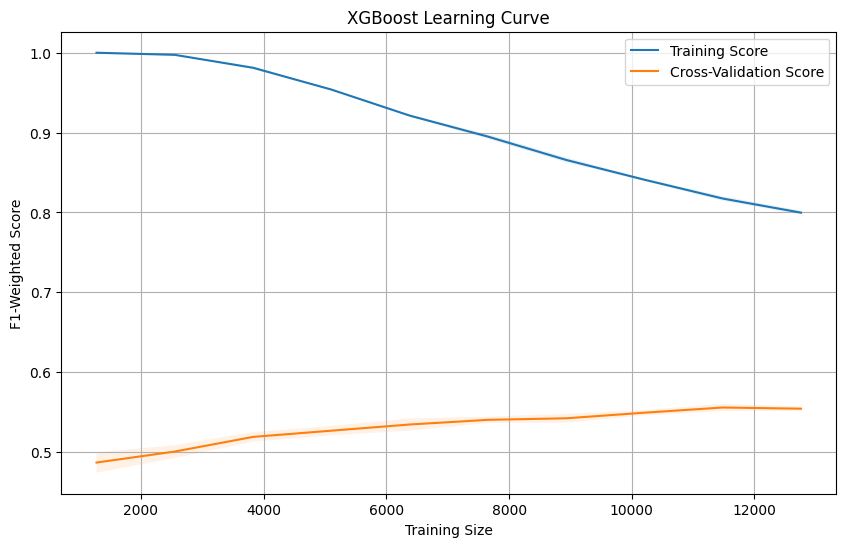

In [1008]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring="f1_weighted", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Size")
plt.ylabel("F1-Weighted Score")
plt.title("XGBoost Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

### **Model 4: LightGBM**

In [1009]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.05, class_weight="balanced", random_state=42
)

In [1010]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 15949, number of used features: 29
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=6,
               n_estimators=200, random_state=42)

In [1011]:
y_pred_lgb = lgb_model.predict(X_test)

In [1012]:
print(classification_report(y_test, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64      2041
           1       0.36      0.79      0.50       414
           2       0.50      0.36      0.42      1533

    accuracy                           0.54      3988
   macro avg       0.50      0.59      0.52      3988
weighted avg       0.56      0.54      0.54      3988



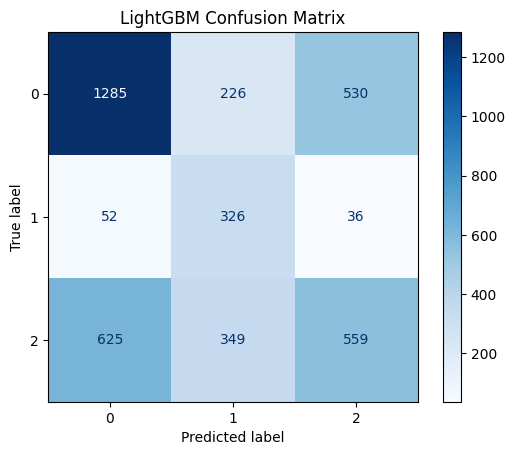

In [1013]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap="Blues")
plt.title("LightGBM Confusion Matrix")
plt.show()

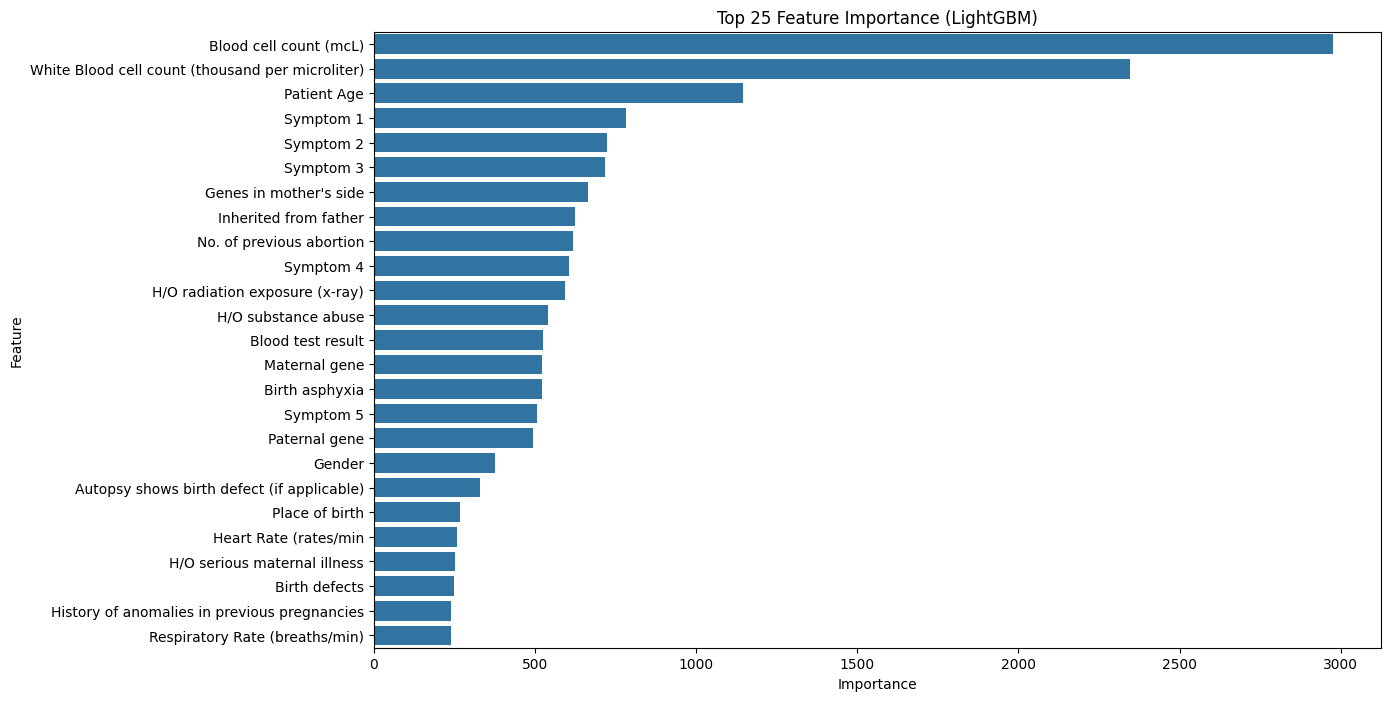

In [1014]:
# Feature Importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": lgb_model.feature_importances_})
feature_importance = feature_importance.sort_values("Importance", ascending=False)
plt.figure(figsize=(13, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(25))
plt.title("Top 25 Feature Importance (LightGBM)")
plt.show()

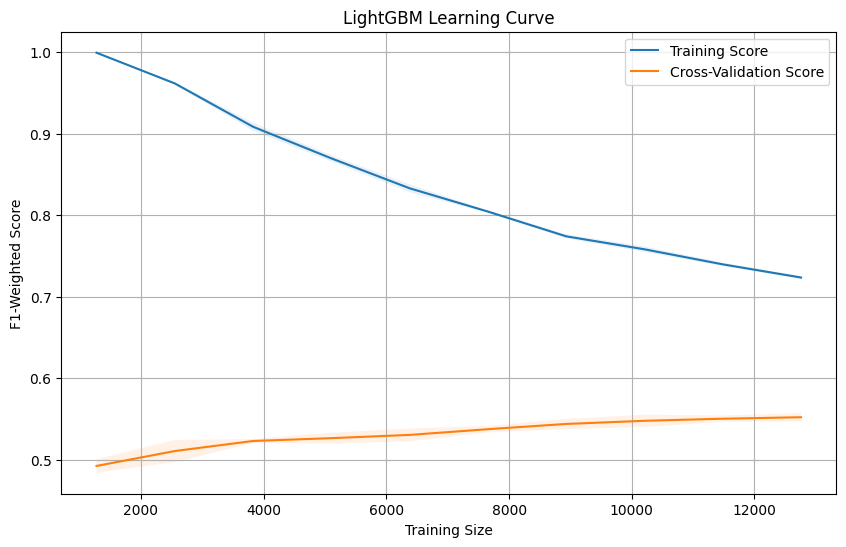

In [1015]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    lgb_model, X_train, y_train, cv=5, scoring="f1_weighted", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Size")
plt.ylabel("F1-Weighted Score")
plt.title("LightGBM Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

### **Model 5: Logistic Regression**

In [1016]:
lr_model = LogisticRegression(
    C=0.1, class_weight="balanced", multi_class="multinomial", solver="lbfgs", max_iter=1000, random_state=42
)

In [1017]:
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)

In [1018]:
y_pred_lr = lr_model.predict(X_test)

In [1019]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.64      0.35      0.45      2041
           1       0.32      0.86      0.47       414
           2       0.40      0.46      0.43      1533

    accuracy                           0.45      3988
   macro avg       0.45      0.56      0.45      3988
weighted avg       0.51      0.45      0.45      3988



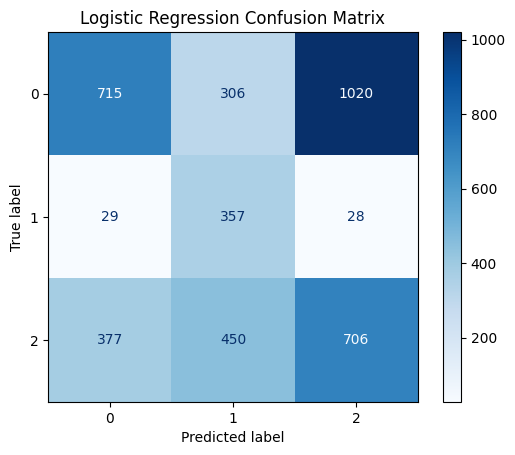

In [1020]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

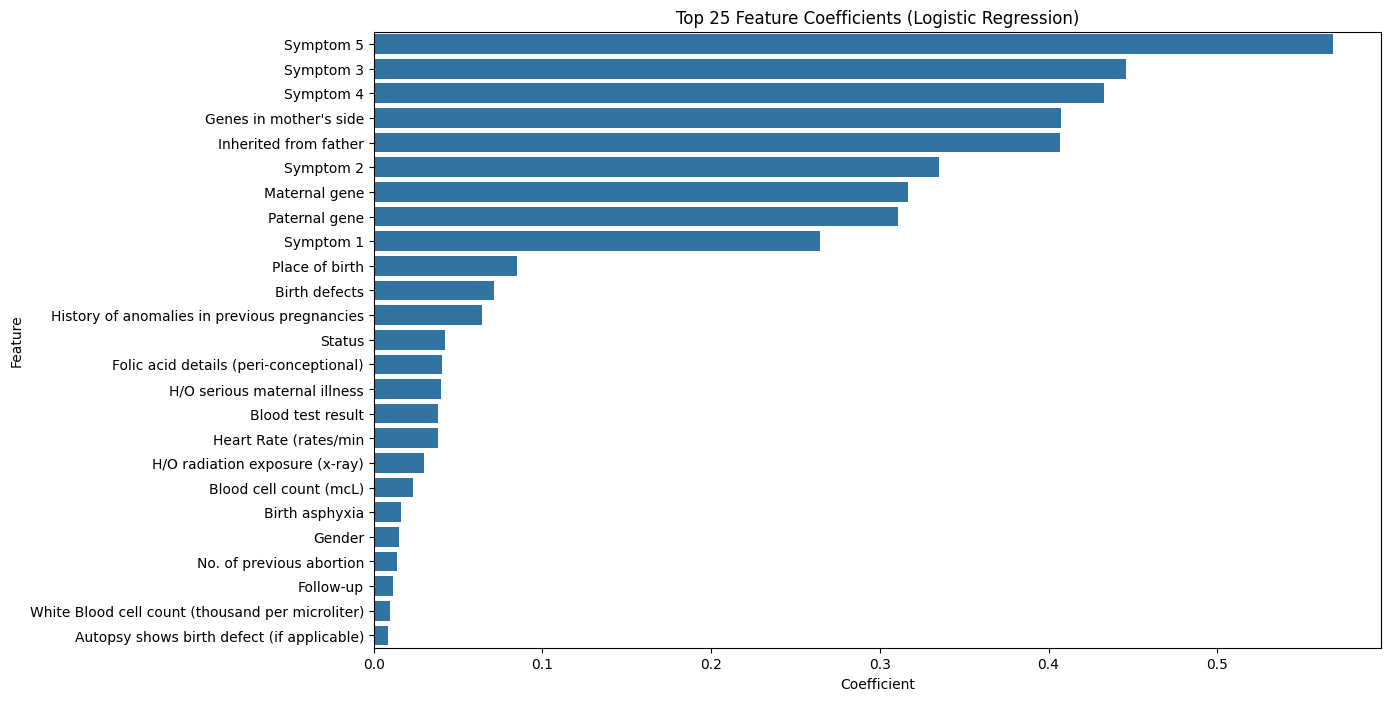

In [1021]:
# Coefficients (Feature Importance)
feature_importance = pd.DataFrame({"Feature": X.columns, "Coefficient": np.abs(lr_model.coef_[1])})
feature_importance = feature_importance.sort_values("Coefficient", ascending=False)
plt.figure(figsize=(13, 8))
sns.barplot(x="Coefficient", y="Feature", data=feature_importance.head(25))
plt.title("Top 25 Feature Coefficients (Logistic Regression)")
plt.show()

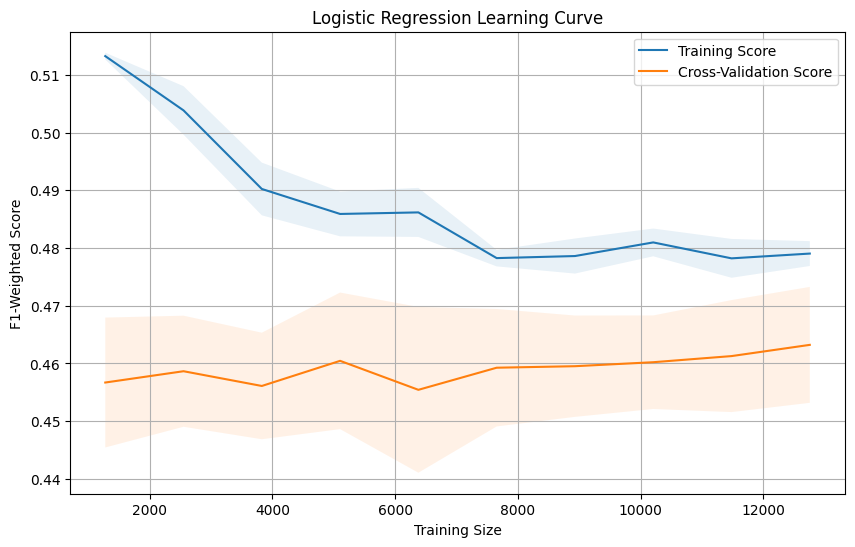

In [1022]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    lr_model, X_train, y_train, cv=5, scoring="f1_weighted", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Size")
plt.ylabel("F1-Weighted Score")
plt.title("Logistic Regression Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

### **Model 6: Support Vector Machine (SVM)**

In [1023]:
svm_model = SVC(C=1.0, kernel="rbf", class_weight="balanced", random_state=42)

In [1024]:
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [1025]:
y_pred_svm = svm_model.predict(X_test)

In [1026]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68      2041
           1       0.36      0.79      0.49       414
           2       0.55      0.31      0.39      1533

    accuracy                           0.56      3988
   macro avg       0.52      0.60      0.52      3988
weighted avg       0.58      0.56      0.55      3988



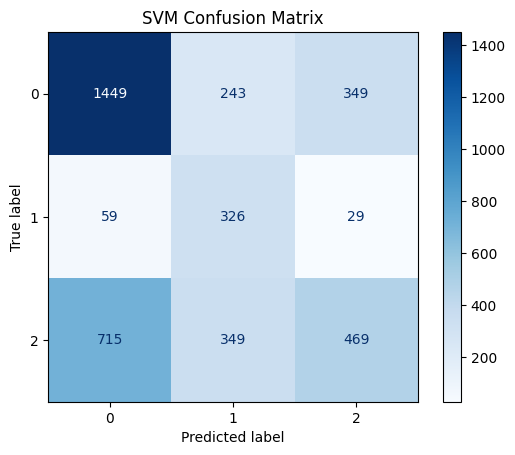

In [1027]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


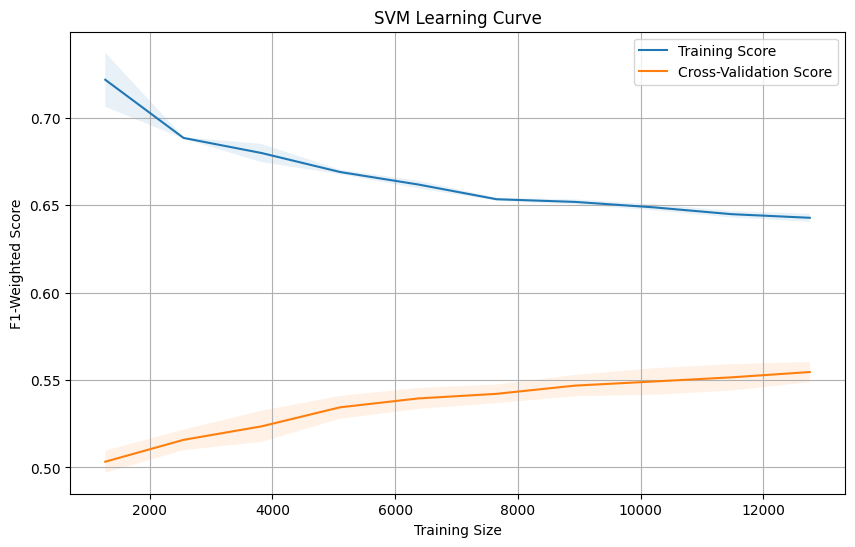

In [1028]:
train_sizes, train_scores, test_scores = learning_curve(
    svm_model, X_train, y_train, cv=5, scoring="f1_weighted", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Size")
plt.ylabel("F1-Weighted Score")
plt.title("SVM Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

### **Model 7: Neural Network (ANN)**

In [270]:
X_train.shape

(15949, 29)

In [267]:
Early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [272]:
model = Sequential()

In [273]:
model.add(Input(shape=(29, )))

In [274]:
model.add(Dense(29, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(15, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(9, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

In [275]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [276]:
model.fit(x=X_train, y=y_train,
          validation_data=(X_test, y_test),
          batch_size=128, epochs=600, callbacks=[Early_stop])

Epoch 1/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3776 - loss: 1.5454 - val_accuracy: 0.5115 - val_loss: 0.9613
Epoch 2/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4214 - loss: 1.2164 - val_accuracy: 0.5108 - val_loss: 0.9385
Epoch 3/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4491 - loss: 1.0711 - val_accuracy: 0.5115 - val_loss: 0.9300
Epoch 4/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4617 - loss: 1.0170 - val_accuracy: 0.5115 - val_loss: 0.9267
Epoch 5/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4843 - loss: 0.9793 - val_accuracy: 0.5115 - val_loss: 0.9248
Epoch 6/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4946 - loss: 0.9596 - val_accuracy: 0.5118 - val_loss: 0.9225
Epoch 7/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5038 - loss: 0.9500 - val_accuracy: 0.5118 - val_loss: 0.9178
Epoch 8/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5142 - loss: 0.9367 - val_accu

In [277]:
model_loss = pd.DataFrame(model.history.history)

<Axes: >

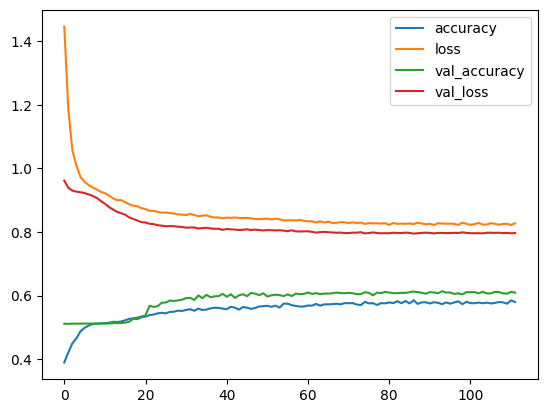

In [278]:
model_loss.plot()

In [279]:
model.evaluate(X_test, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6279 - loss: 0.7810


[0.7966175079345703, 0.6090772151947021]

In [280]:
predict = model.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [282]:
predict[0]

array([0.47414935, 0.12284658, 0.40300405], dtype=float32)

In [283]:
np.argmax(predict[0])

0

In [284]:
predict_label = [np.argmax(i) for i in predict]

In [285]:
print(classification_report(y_test, predict_label))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      2041
           1       0.56      0.15      0.24       414
           2       0.52      0.50      0.51      1533

    accuracy                           0.61      3988
   macro avg       0.58      0.48      0.49      3988
weighted avg       0.60      0.61      0.59      3988



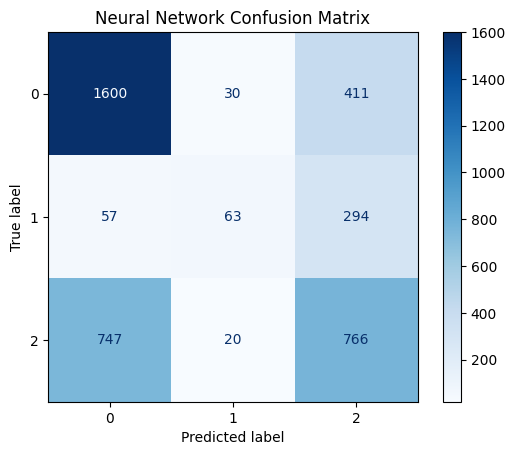

In [286]:
cm = confusion_matrix(y_test, predict_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap="Blues")
plt.title("Neural Network Confusion Matrix")
plt.show()

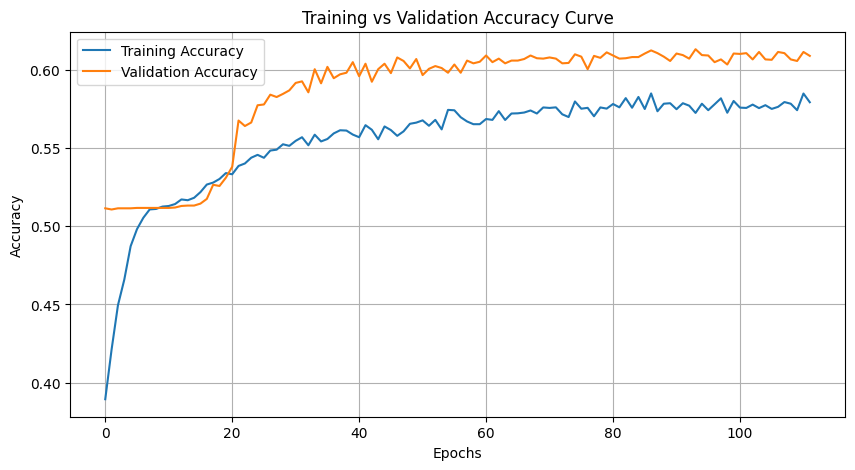

In [297]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(model_loss.index, model_loss["accuracy"], label="Training Accuracy")
plt.plot(model_loss.index, model_loss["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy Curve")
plt.legend()
plt.grid()
plt.show()